In [246]:
import agama
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
from tqdm import tqdm
import os

# Integrating back orbits

The final test for a HVS is proving Galactic Center object, for this purpose we will use the full 6D astrometric solution and integrate back the orbit. If the point in which the object crosses the plane is the galactic center, and we can tell that with enough certainty, then the star will be confirmed as a Hills mechanims origin HVS.

## set up

In [17]:
from dustmaps.config import config
config.reset()


In [20]:
from dustmaps.config import config
config['data_dir'] = '/Data/dustmaps'
import dustmaps.sfd
dustmaps.sfd.fetch()

 64.0 MiB of 64.0 MiB |  12.1 MiB/s |###################| 100% | ETA:  00:00:0000

 64.0 MiB of 64.0 MiB |   7.9 MiB/s |###################| 100% | ETA:  00:00:0000

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

from astropy.coordinates import SkyCoord, Galactocentric
import sys
# Add the path to the 'scripts' folder directly
sys.path.append('/app/data/')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.kde_classifier import *

# galpy

import astropy.units as u
from galpy.orbit import Orbit
from galpy.potential import McMillan17
from galpy.potential import MWPotential2014
from galpy.util.conversion import get_physical
import matplotlib.pyplot as plt
import os

from scipy.stats import gaussian_kde

# Load data

In [248]:
# set current directory to /app/data so we can work with relative paths
os.chdir('/app/data/')


In [249]:
brown_stars = Table.read('Data/Brown_targets/targetsxGaiaEDR3.fits')
brown_stars['ra'] = brown_stars['ra_x']
brown_stars['dec'] = brown_stars['dec_x']

def flux_to_mag(flux):
    return -2.5*np.log10(flux)
brown_stars = extinction_correction(brown_stars)
brown_stars = implied_calculations(brown_stars)


brown_stars['bp_rp_corr_error'] = np.sqrt( flux_to_mag(brown_stars['phot_bp_mean_flux_error'])**2)

brown_stars['implied_M_g_corr'] = compute_absolute_magntiude(brown_stars['G_corr'], 1000/brown_stars['implied_parallax'],[0])
brown_stars['implied_M_g_corr_error'] = compute_absolute_magntiude(brown_stars['G_corr'], 1000/(brown_stars['implied_parallax']
                                                                    + brown_stars['implied_parallax_error']), [0])
brown_stars = brown_stars.to_pandas()
brown_stars['ID'] = brown_stars['ID'].apply(lambda x: x.decode('utf-8').replace(' ', ''))


/usr/local/lib/python3.10/site-packages/astropy/units/core.py:2158: UnitsWarning: 'hms' did not parse as fits unit: At col 0, Unit 'hms' not supported by the FITS standard. Did you mean hm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)

/usr/local/lib/python3.10/site-packages/astropy/units/core.py:2158: UnitsWarning: 'e-/s' did not parse as fits unit: At col 0, Unit 'e' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)

/usr/local/lib/python3.10/site-packages/astropy/units/core.py:2158:

# Define integration function using McMillan potential

In [250]:
from galpy.potential.mwpotentials import McMillan17


# Add proper motions from table 1 Brown 2015

In [251]:
mu_ra = [0.08, -7.33, 0.52, -0.23, 0.55, 0.05, 1, -0.82, -1.26, -1.07, -0.40, -0.9, -1.61, -1.66, -0.96, -1.77]
mu_ra_error = [0.26, 0.58, 0.58, 0.36, 0.61, 0.57, 0.82, 1.16, 0.74, 0.36, 0.36, 0.38, 0.28, 0.52, 0.80, 0.79]

mu_dec = [-0.12, 2.28, 1.65, -0.42, -0.44, 0.31, -0.55, -0.04, -0.25, -0.58, 0.31, 0.46, -0.26, -1.15, 1.55, -3.71 ]
mu_dec_error = [0.22, 0.55, 0.57, 0.36, 0.59, 0.97, 1.04, 0.49, 0.7, 0.42, 0.34, 0.44, 0.42,  0.38, 0.86, 0.89]


# for the ones in gaia drop the 6th one
mu_ra = np.delete(mu_ra, 5)
mu_ra_error = np.delete(mu_ra_error, 5)
mu_dec = np.delete(mu_dec, 5)
mu_dec_error = np.delete(mu_dec_error, 5)

brown_stars['mu_ra'] = mu_ra
brown_stars['mu_ra_error'] = mu_ra_error
brown_stars['mu_dec'] = mu_dec
brown_stars['mu_dec_error'] = mu_dec_error


In [406]:
import agama
agama.setUnits(mass=1, length=1, velocity=1)  # kpc, km/s, 1e10 M_sun
potential_file = 'Agama/McMillan2011.pot'
potential = agama.Potential(potential_file)

# Integrate a single orbit with AGAMA for hvs3

In [407]:

hvs3 = brown_stars.loc[brown_stars['ID'] == 'HVS3']

In [ ]:
import astropy.units as u

# Define AGAMA potential and units
agama.setUnits(mass=1, length=1, velocity=1)  # kpc, km/s, 1e10 M_sun
potential_file = 'Agama/McMillan2011.pot' # should change the name
potential = agama.Potential(potential_file)


integration_time = -0.5 # Gyr

# Define AGAMA potential
potential = agama.Potential(file=potential_file)
agama.setUnits(mass=1.0, length=1.0, velocity=1.0)  # Units: Msun, kpc, km/s

# Transform to Galactocentric frame
coord = SkyCoord(ra=hvs3.ra.values * u.deg, dec=hvs3.dec.values * u.deg, distance=hvs3.d_helio.values * u.kpc, 
                    pm_ra_cosdec=hvs3.mu_ra.values * u.mas/u.yr, pm_dec=hvs3.mu_dec.values * u.mas/u.yr, 
                    radial_velocity=hvs3.v_helio.values * u.km/u.s)

galactic = coord.transform_to(Galactocentric())
x, y, z = galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc)
vx, vy, vz = galactic.v_x.to_value(u.km / u.s), galactic.v_y.to_value(u.km / u.s), galactic.v_z.to_value(u.km / u.s)

# # make x, y, z, vx, vy, vz floats
x, y, z = x[0], y[0], z[0]
vx, vy, vz = vx[0], vy[0], vz[0]

# Prepare initial conditions for AGAMA
ic = np.array([x, y, z, vx, vy, vz])


# print(f"Initial Galactocentric coordinates:")
print(f"X: {x:.2f} kpc, Y: {y:.2f} kpc, Z: {z:.2f} kpc")
print(f"VX: {vx:.2f} km/s, VY: {vy:.2f} km/s, VZ: {vz:.2f} km/s")

# Integrate the orbit

n_steps = 1000

time_grid = np.linspace(0, integration_time, n_steps)

aic=np.array(ic).ravel()

orbit = agama.orbit(potential=potential, ic=aic, time=-0.5, dtype = object)#, trajsize=n_steps)






X: -13.81 kpc, Y: -45.76 kpc, Z: -39.91 kpc
VX: -552.00 km/s, VY: -277.96 km/s, VZ: -416.20 km/s


In [303]:
simplepot=agama.Potential(type='MiyamotoNagai',mass=1e14,scaleRadius=1e-1,scaleHeight=1e-2)
simpleic=np.array([0.1,0,0,0,0,50])

In [334]:
aic=np.array(ic).ravel()
aic

array([ -13.81130556,  -45.75921242,  -39.91322031, -552.00080035,
       -277.96298535, -416.200899  ])

In [354]:
print(potential.Tcirc(np.hstack([aic[:3],0,0,0])))

1.0794314229578112


In [373]:
aic

array([ -13.81130556,  -45.75921242,  -39.91322031, -552.00080035,
       -277.96298535, -416.200899  ])

In [388]:
print(aic)

[ -13.81130556  -45.75921242  -39.91322031 -552.00080035 -277.96298535
 -416.200899  ]


In [400]:
t_aic = np.array([ -12.77872846,  -37.45421054,  -32.66545323, -706.24038735, -426.28235352,
 -226.8772298 ])

In [401]:

orbit = agama.orbit(potential=potential, ic=t_aic, time=-0.5, dtype = object)#, trajsize=n_steps)


In [359]:
time_grid = np.linspace(0, integration_time, n_steps)
orbit = agama.orbit(potential=potential, ic=aic, time=-0.5, dtype = object)#, trajsize=n_steps)


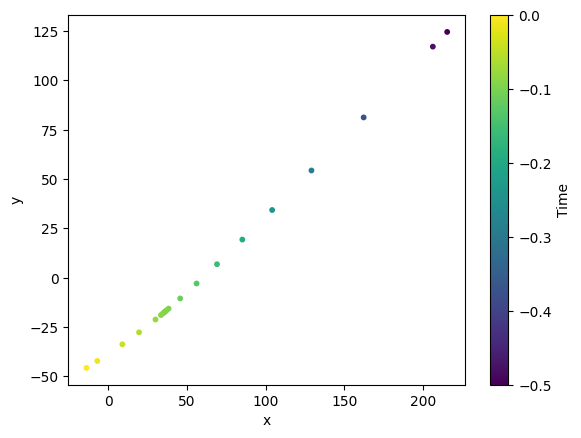

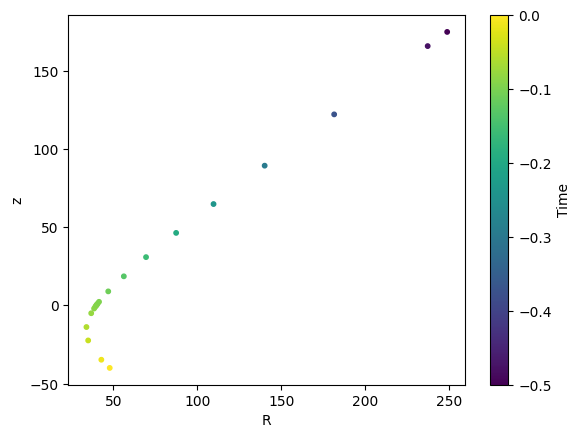

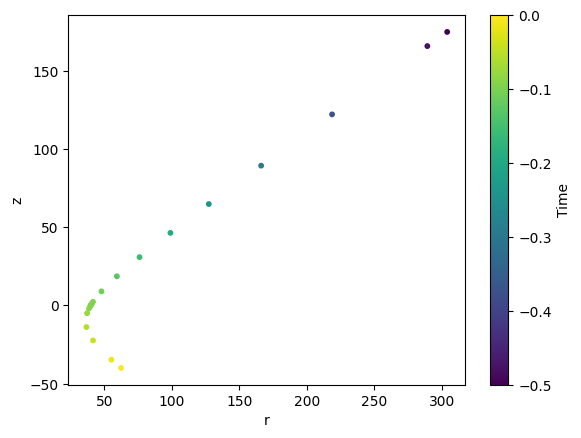

In [ ]:
ts=np.array([t for t in orbit])
trajectory=orbit(orbit)[:,:3]
rs=np.linalg.norm(trajectory,axis=1)
Rs=np.linalg.norm(trajectory[:,:2],axis=1)
vels=orbit(orbit)[:,3:]

ax=plt.gca()
im=ax.scatter(trajectory[:,0],trajectory[:,1],c=ts,s=10)
plt.colorbar(im,label='Time')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

ax=plt.gca()
im=ax.scatter(Rs,trajectory[:,2],c=ts,s=10)
plt.colorbar(im,label='Time')
ax.set_xlabel('R')
ax.set_ylabel('z')
plt.show()

ax=plt.gca()
im=ax.scatter(rs,trajectory[:,2],c=ts,s=10)
plt.colorbar(im,label='Time')
ax.set_xlabel('r')
ax.set_ylabel('z')
plt.show()


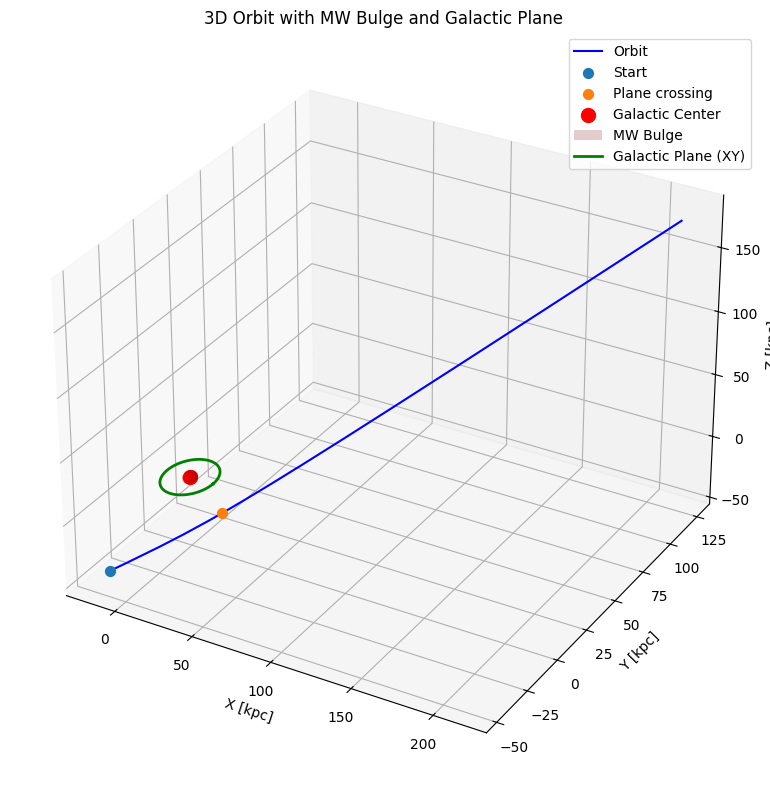

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data from the extracted trajectory
# Replace these with your extracted trajectory data
x_vals = trajectory[:, 0]
y_vals = trajectory[:, 1]
z_vals = trajectory[:, 2]

# Milky Way bulge parameters
bulge_radius = 4  # kpc
mw_radius = 15

# Create the 3D plot
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the orbit
ax.plot(x_vals, y_vals, z_vals, label="Orbit", color="blue", lw=1.5)

# plot the initial and final positions
ax.scatter(x_vals[np.argmin(np.abs(ts))], y_vals[np.argmin(np.abs(ts))], z_vals[np.argmin(np.abs(ts))], s=50, label="Start")
ax.scatter(x_vals[np.argmin(np.abs(z_vals))], y_vals[np.argmin(np.abs(z_vals))], z_vals[np.argmin(np.abs(z_vals))], s=50, label="Plane crossing")
#ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1],  s=50, label="End")

# Plot the Galactic Center
ax.scatter(0, 0, 0, color="red", s=100, label="Galactic Center")

# Plot the Milky Way bulge as a sphere
# Create a sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
sphere_x = bulge_radius * np.outer(np.cos(u), np.sin(v))
sphere_y = bulge_radius * np.outer(np.sin(u), np.sin(v))
sphere_z = bulge_radius * np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(sphere_x, sphere_y, sphere_z, color='red', alpha=0.2, label="MW Bulge")

# Plot the Galactic plane as a circle
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = mw_radius * np.cos(theta)
circle_y = mw_radius * np.sin(theta)
circle_z = np.zeros_like(circle_x)  # XY plane
ax.plot(circle_x, circle_y, circle_z, color='green', label="Galactic Plane (XY)", lw=2)

# Labels and legend
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.set_title("3D Orbit with MW Bulge and Galactic Plane")
ax.legend()




# Adjust view
#ax.view_init(elev=30, azim=65)  # Change elevation and azimuth to view from different angles
plt.tight_layout()
plt.show()


# Sample the orbit error to obtain the posterior

In [ ]:


def integrate_orbits_to_plane_crossing_agama(
    star, ra_col='ra', dec_col='dec', pmra_col='pmra',
    pmdec_col='pmdec', d_col='d_helio', v_col='v_helio',
    pmra_error_col='pmra_error', pmdec_error_col='pmdec_error',
    d_col_error='d_helio_error', v_col_error='v_helio_error',
    output_path=None, n_samples=100, integration_time=-0.5, 
    n_steps=3000
):
    """
    Integrate orbits of a star back in time using AGAMA and find the closest approach to X, Y, Z = 0.

    Parameters:
    - star: pandas.DataFrame
      Single-row DataFrame with columns ['RAx', 'DECx', 'pmra', 'pmdec', 'd_helio', 'v_helio', 
                                         'pmra_error', 'pmdec_error', 'd_helio_error', 'v_helio_error'].
    - output_path: str
      Path to save orbit files (optional).
    - n_samples: int
      Number of Monte Carlo samples for error propagation.
    - integration_time: float
      Integration time into the past (negative for backward integration) in Myr.
    - n_steps: int
      Number of time steps for orbit integration.
      
    Returns:
    - closest_origins: list
      List of positions (X, Y, Z) at the closest approach for each sample.
    """

    # Define AGAMA potential (McMillan17 equivalent)
    potential = agama.Potential(file='Agama/McMillan2011.pot')  # Adjust file path if needed

    from astropy import units as u

    ### galpy uses these units, so instruct agama to do the same
    agama.setUnits( mass=1., length=8., velocity=220.)  # Msun, kpc, km/s


    
    # Extract data and errors
    ra = star[ra_col].iloc[0]
    dec = star[dec_col].iloc[0]
    pmra = star[pmra_col].iloc[0]
    pmdec = star[pmdec_col].iloc[0]
    d_helio = star[d_col].iloc[0]
    v_helio = star[v_col].iloc[0]
    pmra_err = star[pmra_error_col].iloc[0]
    pmdec_err = star[pmdec_error_col].iloc[0]
    d_helio_err = star[d_col_error].iloc[0]
    v_helio_err = star[v_col_error].iloc[0]

    
    # Generate Monte Carlo samples
    ra_samples = np.full(n_samples, ra)
    dec_samples = np.full(n_samples, dec)
    pmra_samples = np.random.normal(pmra, pmra_err, n_samples)
    pmdec_samples = np.random.normal(pmdec, pmdec_err, n_samples)
    d_samples = np.random.normal(d_helio, d_helio_err, n_samples)
    v_samples = np.random.normal(v_helio, v_helio_err, n_samples)
    
    # Initialize output
    closest_origins = []

    # Prepare output directory if saving results
    if output_path:
        os.makedirs(output_path, exist_ok=True)

    # Integrate orbits
    for i in tqdm(range(n_samples)):
        # Transform coordinates to Galactocentric frame
        c = SkyCoord(
            ra=ra_samples[i] * u.deg, dec=dec_samples[i] * u.deg, 
            distance=d_samples[i] * u.kpc, pm_ra_cosdec=pmra_samples[i] * u.mas / u.yr, 
            pm_dec=pmdec_samples[i] * u.mas / u.yr, radial_velocity=v_samples[i] * u.km / u.s
        )
        galactic = c.transform_to(Galactocentric())
        x, y, z = galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc)
        vx, vy, vz = galactic.v_x.to_value(u.km / u.s), galactic.v_y.to_value(u.km / u.s), galactic.v_z.to_value(u.km / u.s)

        # make x, y, z, vx, vy, vz floats
        x, y, z = x[0], y[0], z[0]
        vx, vy, vz = vx[0], vy[0], vz[0]

        # Prepare initial conditions for AGAMA
        ic = [x, y, z, vx, vy, vz]]  
        
        
        # Integrate orbit
        orbit = agama.orbit(potential=potential, ic=ic, time=integration_time, trajsize=n_steps)

        # extract time steps and trajectory
        time_steps = orbit[0, 0]  # Array of time steps
        trajectory = orbit[0, 1]  # 2D array with X, Y, Z, VX, VY, VZ

        # Split trajectory into positions and velocities
        x_vals, y_vals, z_vals = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]
        vx_vals, vy_vals, vz_vals = trajectory[:, 3], trajectory[:, 4], trajectory[:, 5]

        positions = [x_vals, y_vals, z_vals]

        # Find the closest approach to the Galactic plane (Z=0)
        distances = np.abs(z_vals)  # Z values
        min_idx = np.argmin(distances)
        periapse = (x_vals[min_idx], y_vals[min_idx], z_vals[min_idx])
        closest_origins.append(periapse)
        
        # Save orbit data to file (optional)
        if output_path:
            filename = os.path.join(output_path, f"star_sample_{i}.txt")
            np.savetxt(filename, orbit, header="X [kpc]    Y [kpc]    Z [kpc]    VX [km/s]    VY [km/s]    VZ [km/s]")
    
    return closest_origins


In [468]:


def integrate_orbits_to_plane_crossing_agama(
    star, ra_col='ra', dec_col='dec', pmra_col='pmra',
    pmdec_col='pmdec', d_col='d_helio', v_col='v_helio',
    pmra_error_col='pmra_error', pmdec_error_col='pmdec_error',
    d_col_error='d_helio_error', v_col_error='v_helio_error',
    output_path=None, n_samples=100, integration_time=-0.5, 
):
    """
    Integrate orbits of a star back in time using AGAMA and find the closest approach to X, Y, Z = 0.

    Parameters:
    - star: pandas.DataFrame
      Single-row DataFrame with columns ['RAx', 'DECx', 'pmra', 'pmdec', 'd_helio', 'v_helio', 
                                         'pmra_error', 'pmdec_error', 'd_helio_error', 'v_helio_error'].
    - output_path: str
      Path to save orbit files (optional).
    - n_samples: int
      Number of Monte Carlo samples for error propagation.
    - integration_time: float
      Integration time into the past (negative for backward integration) in Myr.
    - n_steps: int
      Number of time steps for orbit integration.
      
    Returns:
    - closest_origins: list
      List of positions (X, Y, Z) at the closest approach for each sample.
    """


    #potential = agama.Potential(file='Agama/McMillan2011.pot')  # Adjust file path if needed
    # just in case
    agama.setUnits(mass=1, length=1, velocity=1)  # kpc, km/s, 1e10 M_sun
    
    # Define AGAMA potential (McMillan17 equivalent)
    potential_file = 'Agama/McMillan2011.pot'
    potential = agama.Potential(potential_file)

    from astropy import units as u

    ### galpy uses these units, so instruct agama to do the same
    #agama.setUnits( mass=1., length=1, velocity=1)  # Msun, kpc, km/s


    
    # Extract data and errors
    ra = star[ra_col].iloc[0]
    dec = star[dec_col].iloc[0]
    pmra = star[pmra_col].iloc[0]
    pmdec = star[pmdec_col].iloc[0]
    d_helio = star[d_col].iloc[0]
    v_helio = star[v_col].iloc[0]
    pmra_err = star[pmra_error_col].iloc[0]
    pmdec_err = star[pmdec_error_col].iloc[0]
    d_helio_err = star[d_col_error].iloc[0]
    v_helio_err = star[v_col_error].iloc[0]

    
    # Generate Monte Carlo samples
    ra_samples = np.full(n_samples, ra)
    dec_samples = np.full(n_samples, dec)
    pmra_samples = np.random.normal(pmra, pmra_err, n_samples)
    pmdec_samples = np.random.normal(pmdec, pmdec_err, n_samples)
    d_samples = np.random.normal(d_helio, d_helio_err, n_samples)
    v_samples = np.random.normal(v_helio, v_helio_err, n_samples)
    
    # Initialize output
    closest_origins = []

    # Prepare output directory if saving results
    if output_path:
        os.makedirs(output_path, exist_ok=True)

    # Integrate orbits
    for i in tqdm(range(n_samples)):
        # Transform coordinates to Galactocentric frame
        c = SkyCoord(
            ra=ra_samples[i] * u.deg, dec=dec_samples[i] * u.deg, 
            distance=d_samples[i] * u.kpc, pm_ra_cosdec=pmra_samples[i] * u.mas / u.yr, 
            pm_dec=pmdec_samples[i] * u.mas / u.yr, radial_velocity=v_samples[i] * u.km / u.s
        )
        galactic = c.transform_to(Galactocentric())
        x, y, z = galactic.x.to_value(u.kpc), galactic.y.to_value(u.kpc), galactic.z.to_value(u.kpc)
        vx, vy, vz = galactic.v_x.to_value(u.km / u.s), galactic.v_y.to_value(u.km / u.s), galactic.v_z.to_value(u.km / u.s)

        # Prepare initial conditions for AGAMA
        ic = np.array([x, y, z, vx, vy, vz])  # Initial conditions
        
        # Integrate orbit
        orbit = agama.orbit(potential=potential, ic=ic, time=integration_time, dtype = object)#, trajsize=n_steps)

        # extract time steps and trajectory
        ts=np.array([t for t in orbit])
        trajectory=orbit(orbit)[:,:3]
        rs=np.linalg.norm(trajectory,axis=1)
        Rs=np.linalg.norm(trajectory[:,:2],axis=1)
        vels=orbit(orbit)[:,3:]


        # Split trajectory into positions and velocities
        x_vals, y_vals, z_vals = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]
        positions = [x_vals, y_vals, z_vals]

        # Find the closest approach to the Galactic plane (Z=0)
        distances = np.abs(z_vals)  # Z values
        min_idx = np.argmin(distances)
        periapse = (x_vals[min_idx], y_vals[min_idx], z_vals[min_idx])
        closest_origins.append(periapse)
        
        # Save orbit data to file (optional)
        if output_path:
            filename = os.path.join(output_path, f"star_sample_{i}.txt")
            np.savetxt(filename, orbit, header="X [kpc]    Y [kpc]    Z [kpc]    VX [km/s]    VY [km/s]    VZ [km/s]")
    
    return closest_origins


In [432]:


plane_crossing_hvs3 = integrate_orbits_to_plane_crossing_agama(hvs3, n_samples=1000,
                                                            integration_time=-0.5,  pmra_col='mu_ra',
                                                            pmdec_col='mu_dec',
                                                            pmra_error_col='mu_ra_error',
                                                            pmdec_error_col='mu_dec_error')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 252.54it/s]


In [421]:
def plot_closest_origins(origins, xlim=(-60, 60), ylim=(-60, 60)):
    """
    Plot the closest approach points in the X-Y plane.
    
    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    """
    # Extract X, Y positions
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])
    
    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    #xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Plot the KDE as a contour plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xi, yi, zi, levels=30, cmap="Blues")
    plt.colorbar(label="Density")
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Mark the Galactic Center

    # solar circle
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    # add circle with a 15 kpc radius
    circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='15 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('Closest Approach Points in X-Y Plane')
    plt.legend(loc = 'upper right')
    plt.grid(True)
    plt.show()


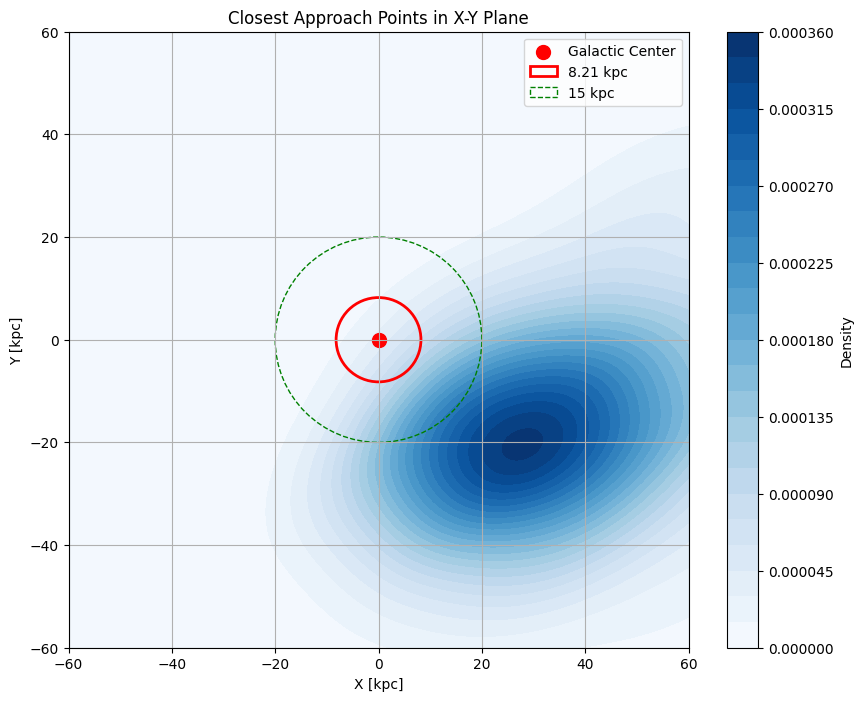

In [422]:
plot_closest_origins(plane_crossing_hvs3, xlim=(-60, 60), ylim=(-60, 60))

In [488]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_sigma_contours(origins, xlim=(-60, 60), ylim=(-60, 60)):
    """
    Plot the 1σ and 2σ contours of closest approach points in the X-Y plane.
    
    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
    
    # Normalize the KDE to get cumulative probabilities
    zi_flat = zi.flatten()
    sorted_zi = np.sort(zi_flat)
    cumsum_zi = np.cumsum(sorted_zi) / np.sum(sorted_zi)
    
    # Determine contour levels for 1σ (68%) and 2σ (95%)
    level_1sigma = sorted_zi[np.searchsorted(cumsum_zi, 0.68)]
    level_2sigma = sorted_zi[np.searchsorted(cumsum_zi, 0.95)]

    # Define KDE levels
    levels=np.linspace(zi.min(), zi.max(), 100)

    # Make sure that levels are increasing and spaced
    levels = np.sort(np.unique(levels))

    #print(f"zi min: {zi.min()}, zi max: {zi.max()}")
    #print(f"1σ level: {level_1sigma}, 2σ level: {level_2sigma}")
    
    # Plot the KDE with contour levels
    plt.figure(figsize=(10, 8))
    plt.contourf(xi, yi, zi, levels = levels, cmap="Blues")
    plt.colorbar(label="Density")
    plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'], 
                linewidths=[2, 2], linestyles=['--', '-'], labels=['1σ', '2σ'])
    
    # solar circle
    circle1 = plt.Circle((0, 0), 8.21, color='r', fill=False, lw=2, label='8.21 kpc')
    # add circle with a 15 kpc radius
    circle2 = plt.Circle((0, 0), 20, color='g', fill=False, linestyle='--', label='20 kpc')
    plt.gca().add_artist(circle1)
    plt.gca().add_artist(circle2)
    
    # Add annotations
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('1σ and 2σ Contours of Closest Approach Points in X-Y Plane')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()




/tmp/ipykernel_15/3344737526.py:50: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'],



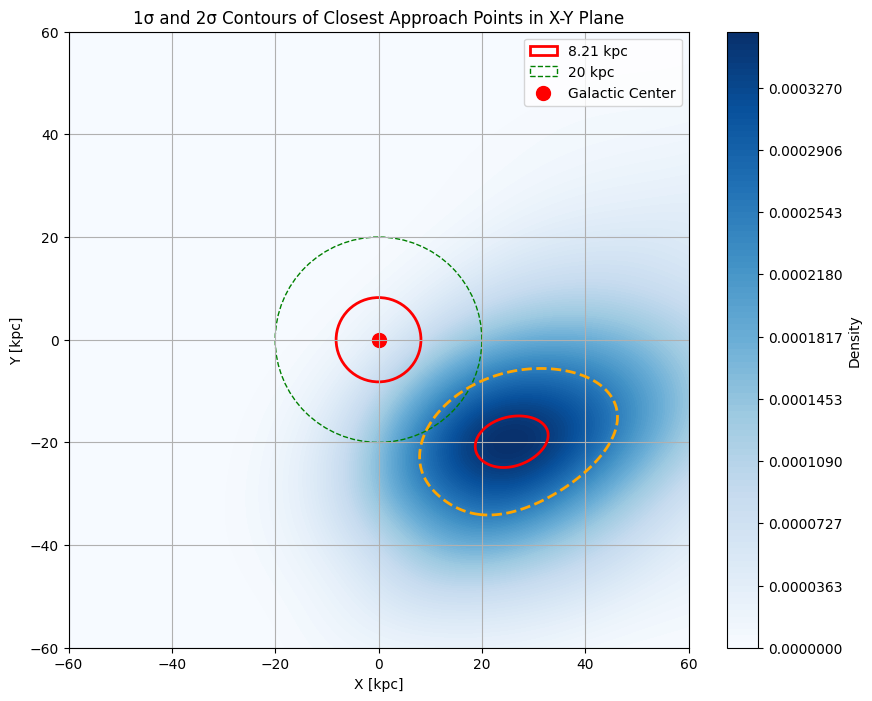

In [489]:
plot_sigma_contours(plane_crossing_hvs3)

# Test with Brown proper motions on HVS4

# Hubble x Gaia

In [492]:
# load hvs4 data
hvs4 = Table.read('Data/Brown_targets/hvs4_hubblexgaia_rewind.fits')
hvs4 = hvs4.to_pandas()

/usr/local/lib/python3.10/site-packages/astropy/units/core.py:2158: UnitsWarning: 'hms' did not parse as fits unit: At col 0, Unit 'hms' not supported by the FITS standard. Did you mean hm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)



## Test with Gaia proper motions

In [494]:
origin_hvs4 = integrate_orbits_to_plane_crossing_agama(hvs4, n_samples=1000, integration_time=-0.1,
                                                          ra_col='ra_1', dec_col='dec_1',
                                                          pmra_col = 'pmra', 
                                                          pmdec_col='pmdec', 
                                                          pmra_error_col='pmra_error', 
                                                          pmdec_error_col='pmdec_error')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 257.91it/s]


/tmp/ipykernel_15/3344737526.py:50: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'],



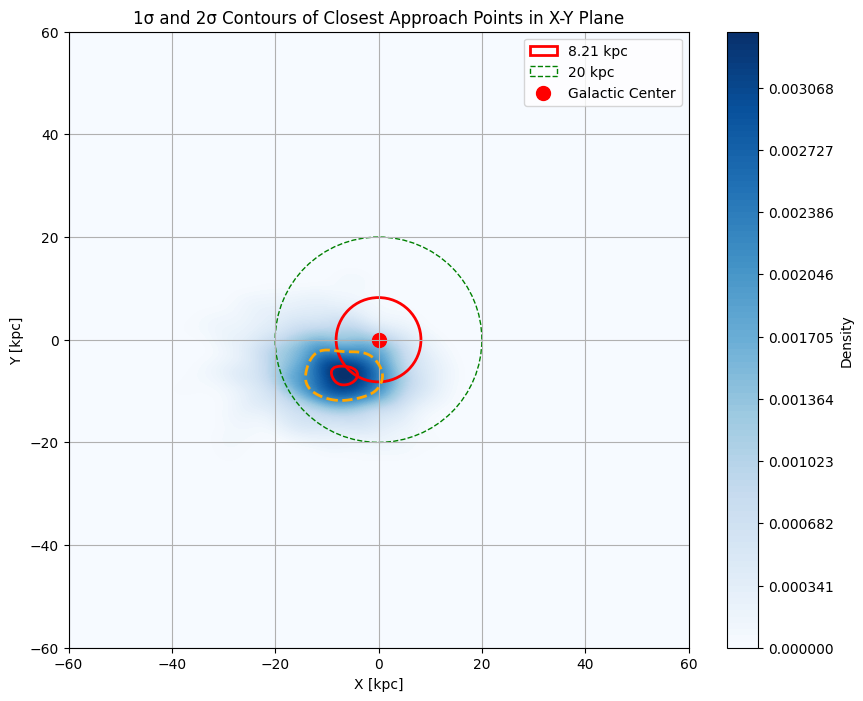

In [495]:
plot_sigma_contours(origin_hvs4)

## Test with Gaiahub proper motions

In [496]:
origin_hvs4 = integrate_orbits_to_plane_crossing_agama(hvs4, n_samples=1000, integration_time=-0.1,
                                                          ra_col='ra_1', dec_col='dec_1',
                                                          pmra_col = 'hst_gaia_pmra_wmean', 
                                                          pmdec_col='hst_gaia_pmdec_wmean', 
                                                          pmra_error_col='hst_gaia_pmra_wmean_error', 
                                                          pmdec_error_col='hst_gaia_pmdec_wmean_error')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 254.45it/s]


/tmp/ipykernel_15/3344737526.py:50: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'],



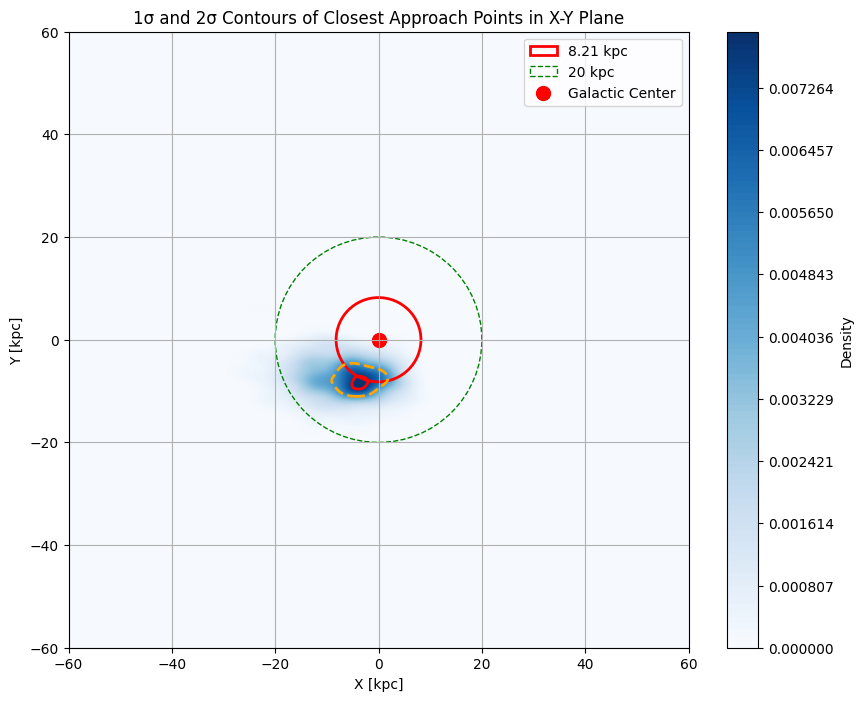

In [497]:
plot_sigma_contours(origin_hvs4)

# HVS 1

In [435]:
# load hvs4 data
hvs = Table.read('Data/Brown_targets/hvs1_hubblexgaia.fits')
hvs = hvs.to_pandas()

/usr/local/lib/python3.10/site-packages/astropy/units/core.py:2158: UnitsWarning: 'hms' did not parse as fits unit: At col 0, Unit 'hms' not supported by the FITS standard. Did you mean hm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)



In [436]:
hvs

SOURCE_ID           l          b        ra_1  ra_error     dec_1  \
0  577294697514301440  227.335374  31.331994  136.937465  0.450432  2.751909   

   dec_error  parallax  parallax_error      pmra  ...  Mg_error         g0  \
0   0.318181  0.190676        0.580638 -0.603939  ...      0.31  19.690001   

   g0_error d_helio d_helio_error           RA_2           DEC_2         RAx  \
0      23.0   102.0          15.0  b'9:07:44.99'  b'+02:45:06.9'  136.937458   

       DECx  Separation  
0  2.751917     0.03775  

[1 rows x 133 columns]

In [442]:
origin_hvs = integrate_orbits_to_plane_crossing_agama(hvs, n_samples=1000, integration_time=-100,
                                                          ra_col='ra_1', dec_col='dec_1',
                                                          pmra_col = 'pmra', 
                                                          pmdec_col='pmdec', 
                                                          pmra_error_col='pmra_error', 
                                                          pmdec_error_col='pmdec_error')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.39it/s]


In [440]:
def plot_sigma_contours_2(origins, xlim=(-60, 60), ylim=(-60, 60)):
    """
    Plot the 1σ and 2σ contours of closest approach points in the X-Y plane, 
    and mark the current coordinates of the LMC.
    
    Parameters:
    - origins: list of tuples
      List of positions (X, Y, Z) at the closest approach for each sample.
    - xlim: tuple
      Limits for the X-axis (default: (-60, 60)).
    - ylim: tuple
      Limits for the Y-axis (default: (-60, 60)).
    """
    # Extract X, Y positions from origins
    x = np.array([origin[0] for origin in origins])
    y = np.array([origin[1] for origin in origins])

    # Create a 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    xi, yi = np.linspace(xlim[0], xlim[1], 300), np.linspace(ylim[0], ylim[1], 300)
    xi, yi = np.meshgrid(xi, yi)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

    # Check for zero density
    if np.all(zi == 0):
        print("All density values are zero. Plotting data points directly.")
        plt.figure(figsize=(10, 8))
        plt.scatter(x, y, s=10, label="Closest Approach Points", color="blue")
        plt.scatter(0, 0, color="red", label="Galactic Center", s=100)  # Galactic Center
        plt.xlabel('X [kpc]')
        plt.ylabel('Y [kpc]')
        plt.xlim(x.min() - 5, x.max() + 5)
        plt.ylim(y.min() - 5, y.max() + 5)
        plt.title('Closest Approach Points in X-Y Plane')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
        return

    # Normalize the KDE to get cumulative probabilities
    zi_flat = zi.flatten()
    sorted_zi = np.sort(zi_flat)
    cumsum_zi = np.cumsum(sorted_zi) / np.sum(sorted_zi)
    
    # Determine contour levels for 1σ (68%) and 2σ (95%)
    level_1sigma = sorted_zi[np.searchsorted(cumsum_zi, 0.68)]
    level_2sigma = sorted_zi[np.searchsorted(cumsum_zi, 0.95)]

    # Plot the KDE with contour levels
    plt.figure(figsize=(10, 8))
    levels = np.linspace(zi.min(), zi.max(), 100) if zi.max() > zi.min() else [zi.min(), zi.max() + 1e-6]
    plt.contourf(xi, yi, zi, levels=levels, cmap="Blues")
    plt.colorbar(label="Density")
    plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'], 
                linewidths=[2, 2], linestyles=['--', '-'], labels=['1σ', '2σ'])
    
    # Add annotations
    plt.scatter(0, 0, color='red', label='Galactic Center', s=100)  # Galactic Center
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title('1σ and 2σ Contours of Closest Approach Points in X-Y Plane')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


/tmp/ipykernel_15/2776402030.py:55: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'],



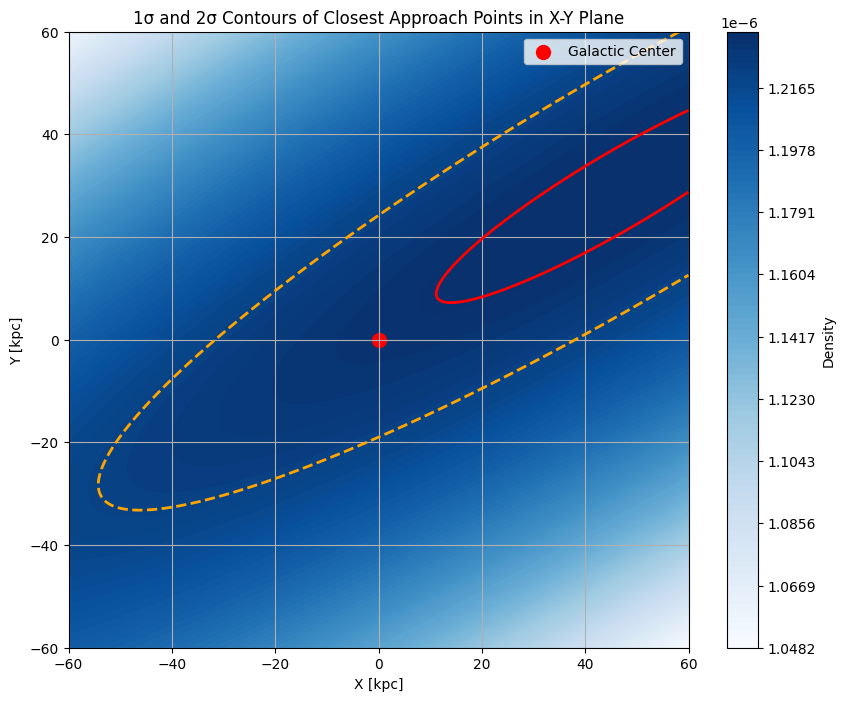

In [443]:
plot_sigma_contours_2(origin_hvs)

# Run all of Brown targets with AGAMA

## With Gaia proper motions

In [451]:

plane_crossing = []
for i in tqdm(range(len(brown_stars))):
    origins = integrate_orbits_to_plane_crossing_agama(brown_stars.iloc[[i]], integration_time=-0.1, n_samples=1000)
    plane_crossing.append(origins)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:55<00:00,  3.68s/it]


0    HVS1
Name: ID, dtype: object


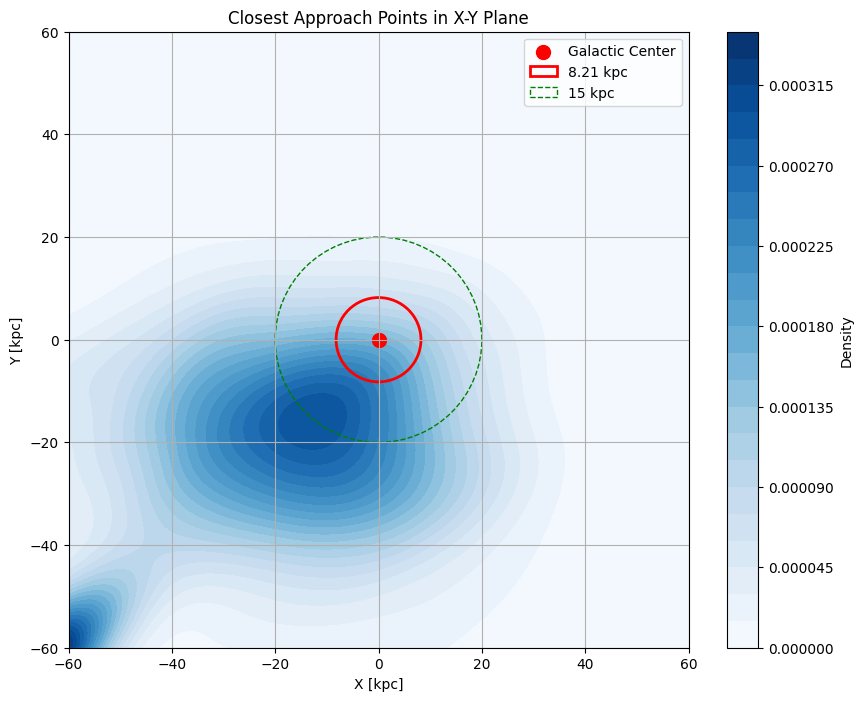

1    HVS2
Name: ID, dtype: object


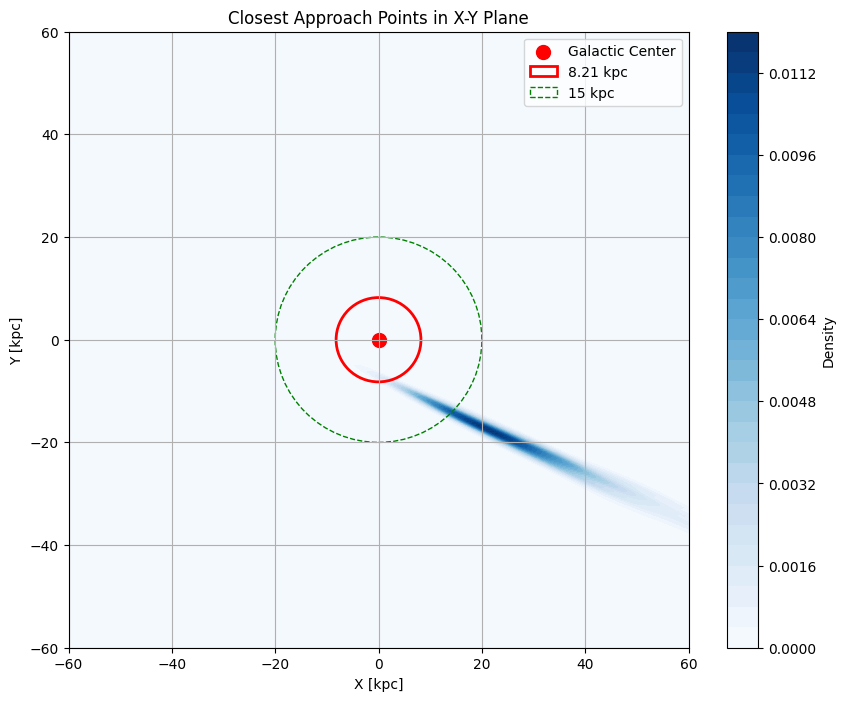

2    HVS3
Name: ID, dtype: object


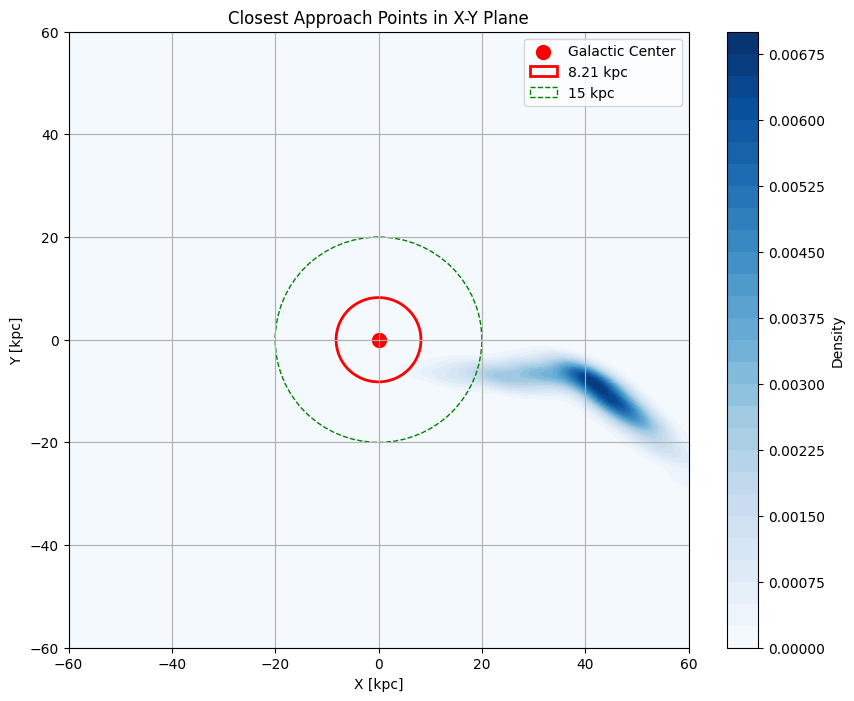

3    HVS4
Name: ID, dtype: object


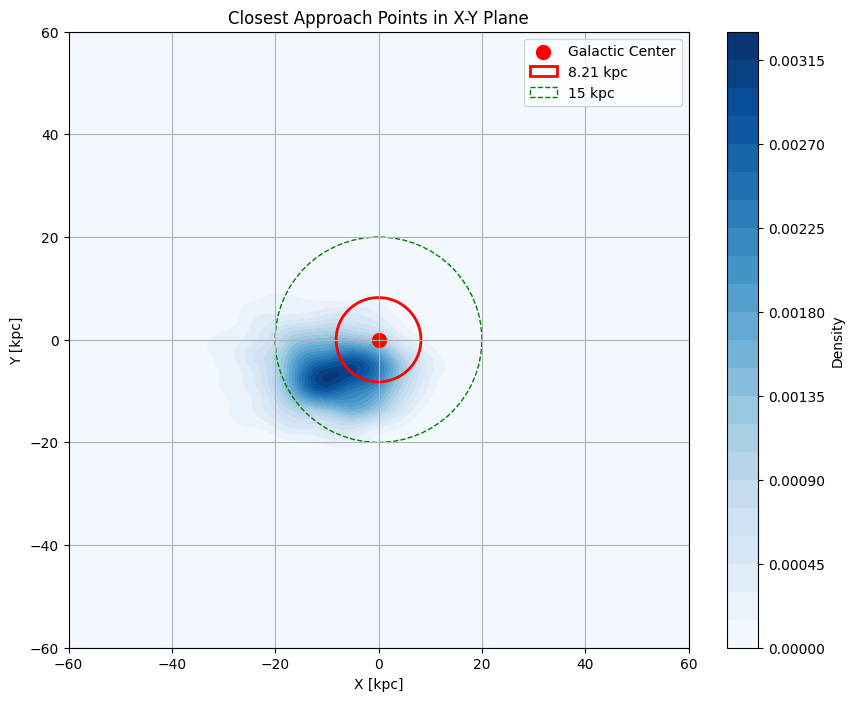

4    HVS5
Name: ID, dtype: object


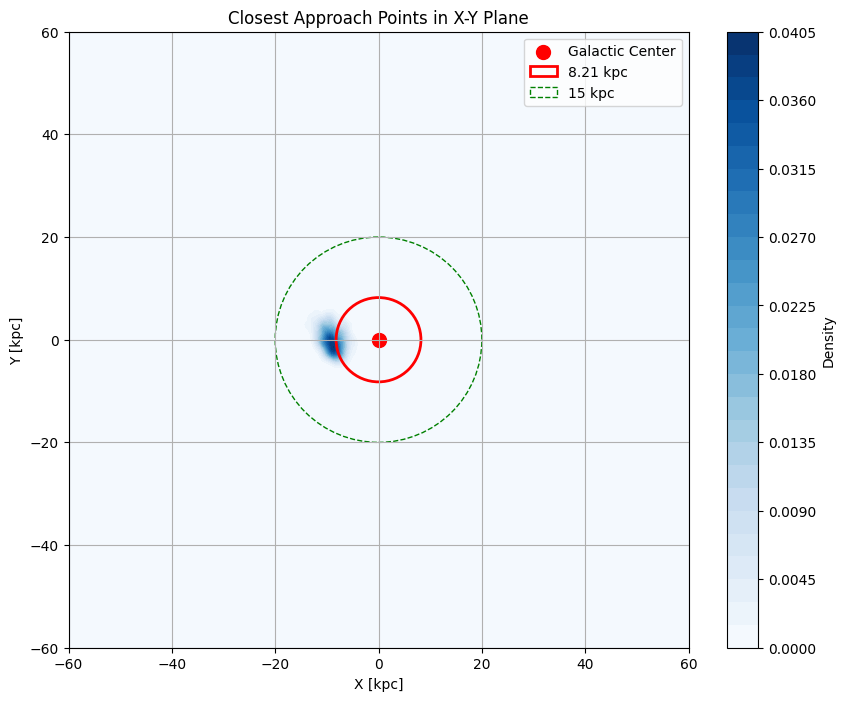

5    HVS7
Name: ID, dtype: object


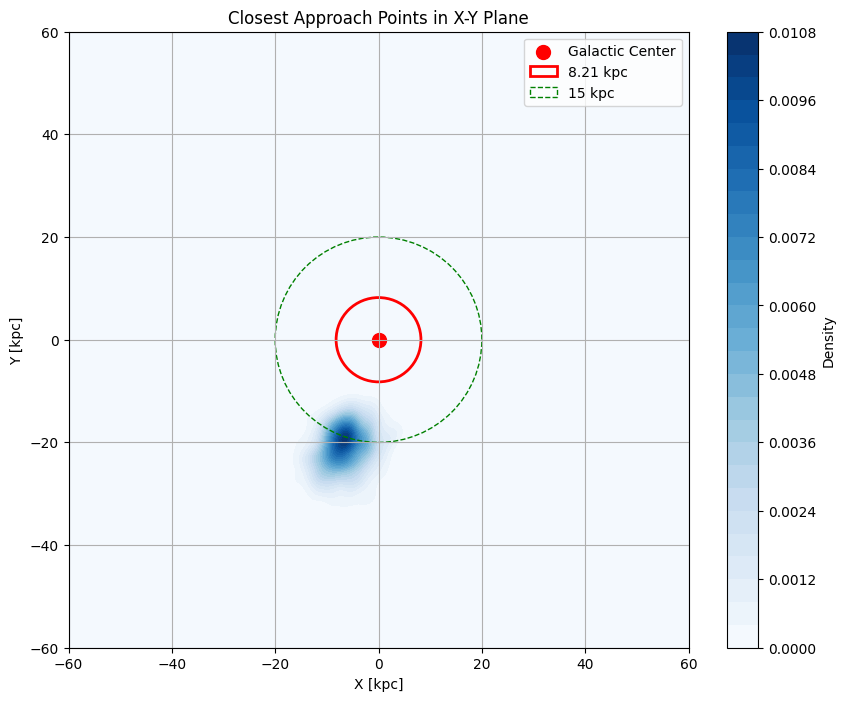

6    HVS8
Name: ID, dtype: object


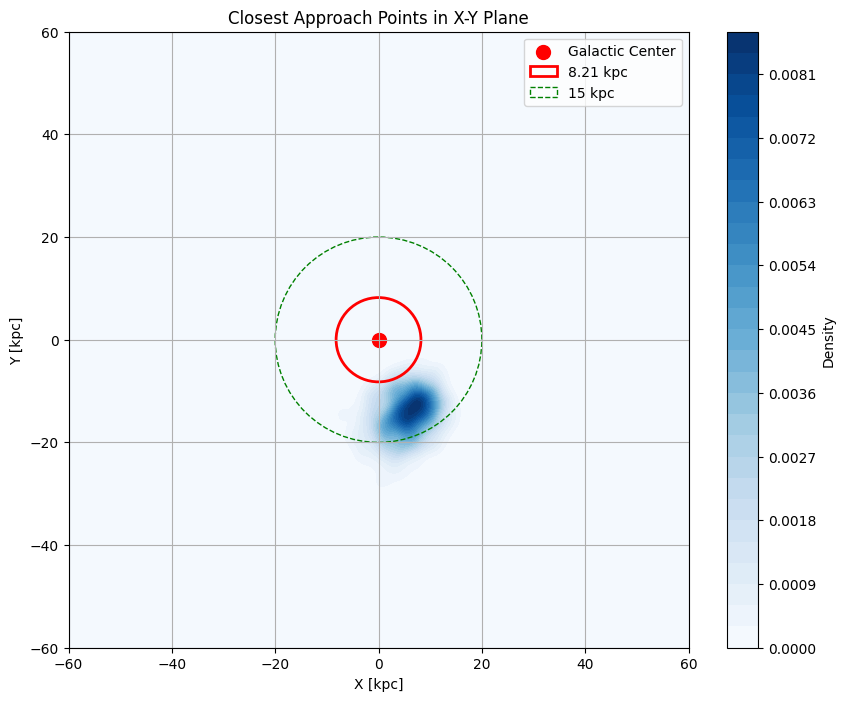

7    HVS9
Name: ID, dtype: object


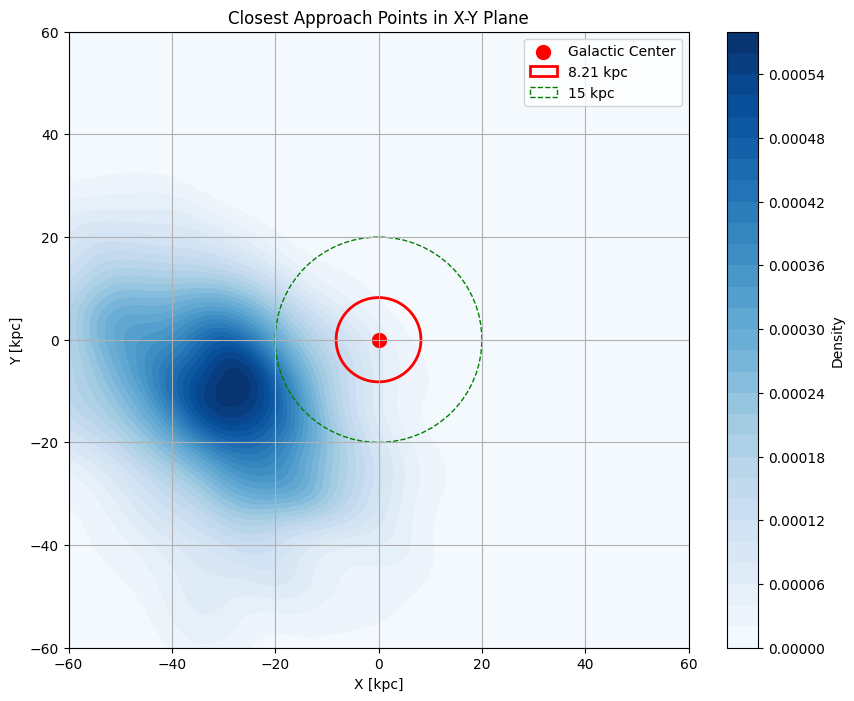

8    HVS10
Name: ID, dtype: object


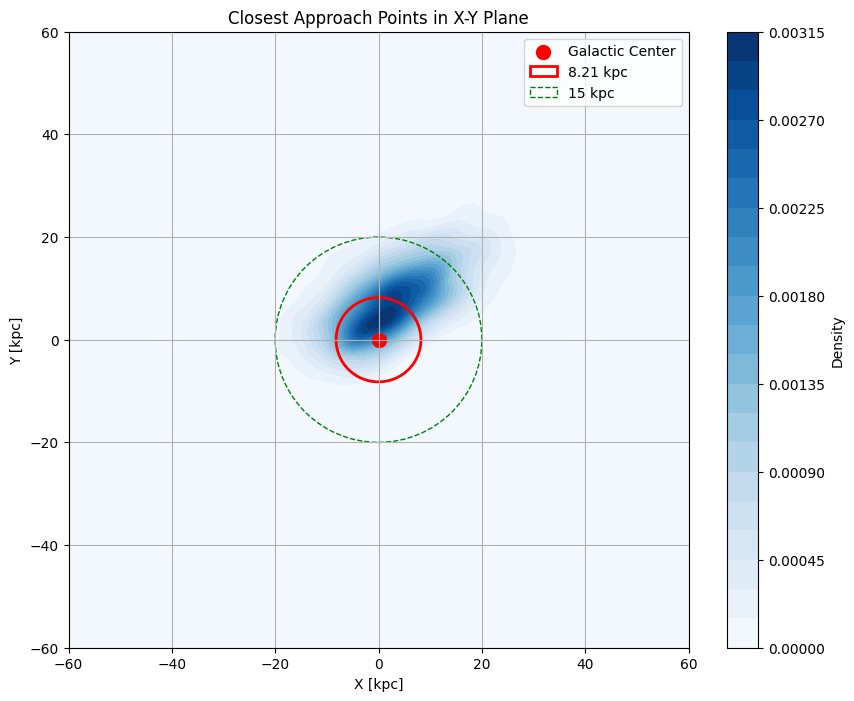

9    HVS12
Name: ID, dtype: object


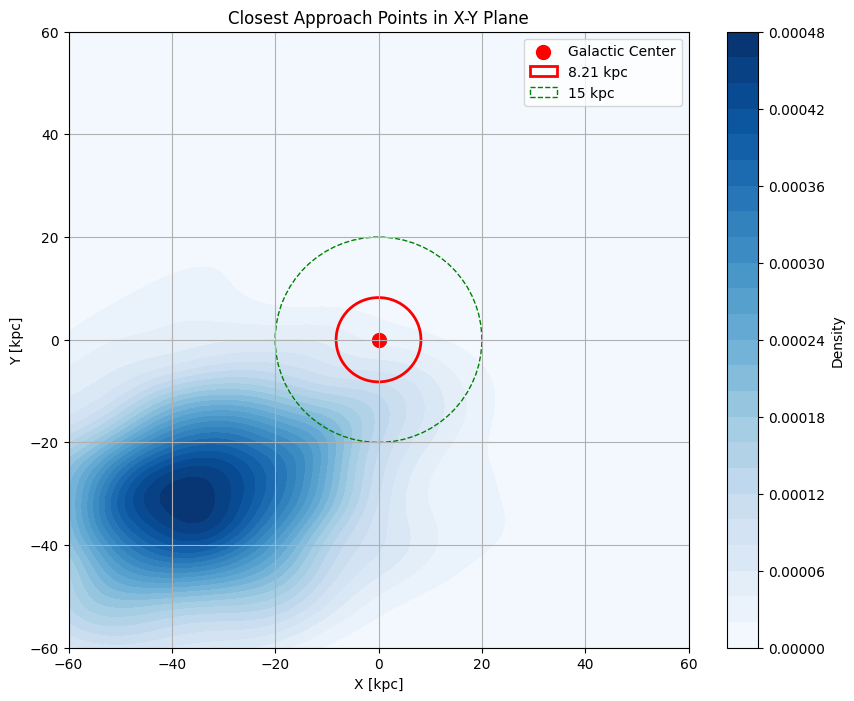

10    HVS13
Name: ID, dtype: object


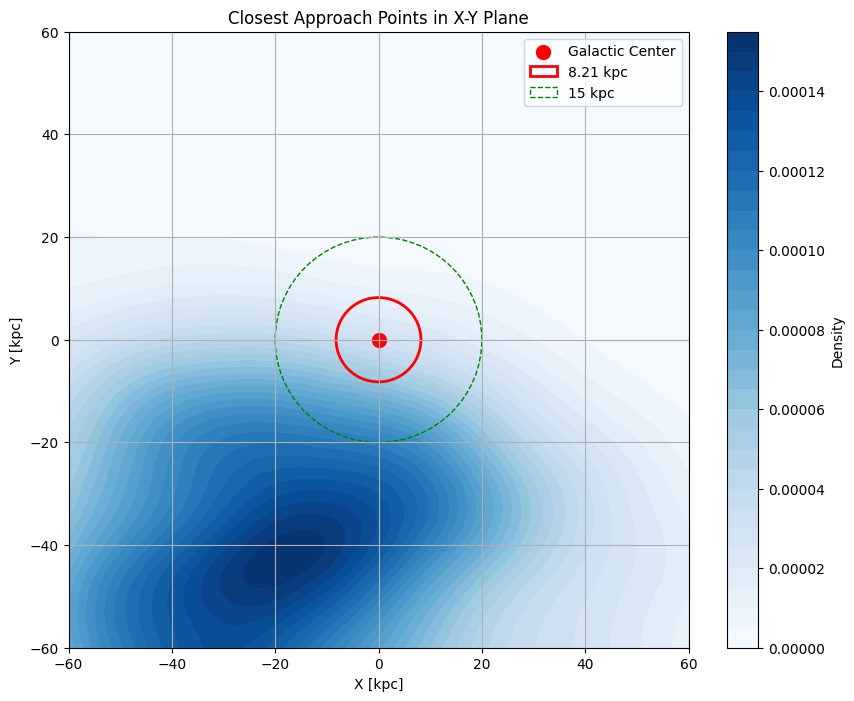

11    B434
Name: ID, dtype: object


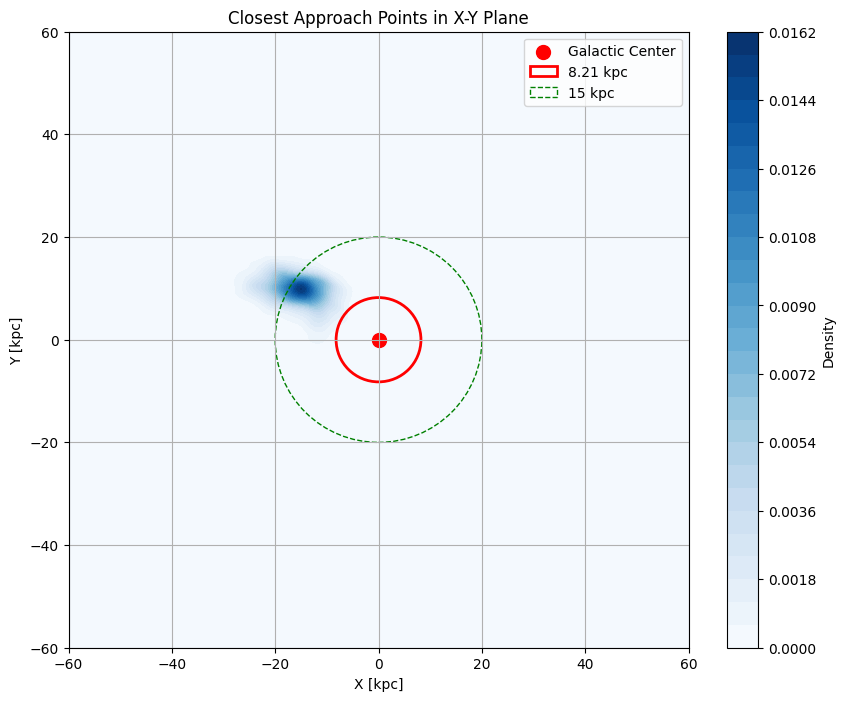

12    B485
Name: ID, dtype: object


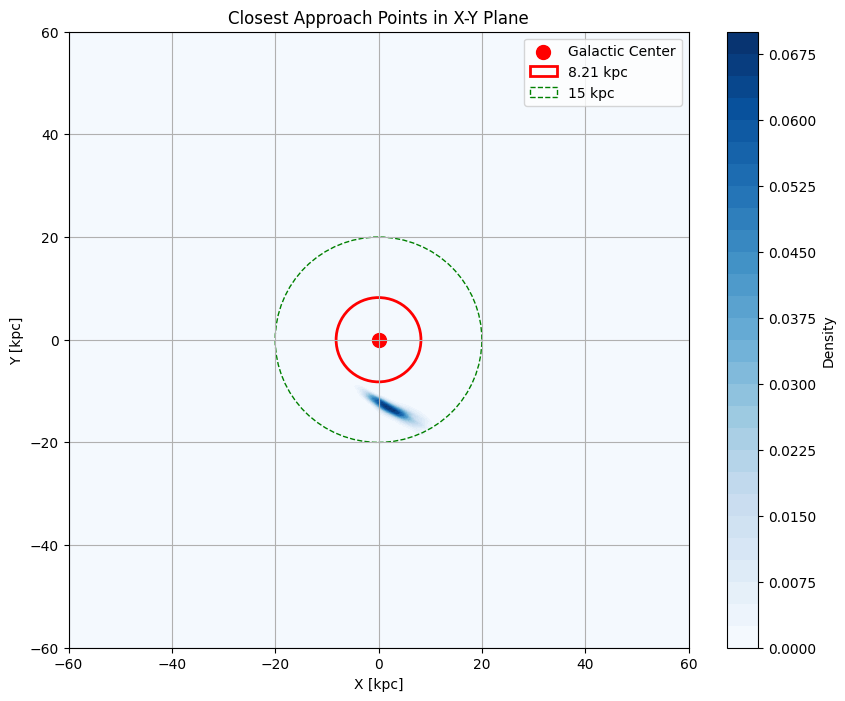

13    B711
Name: ID, dtype: object


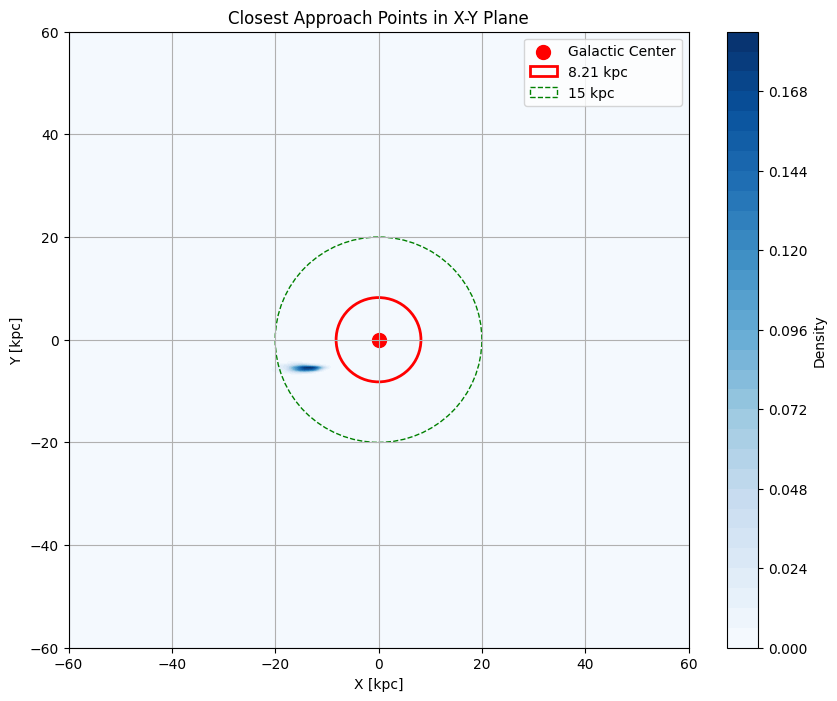

14    B733
Name: ID, dtype: object


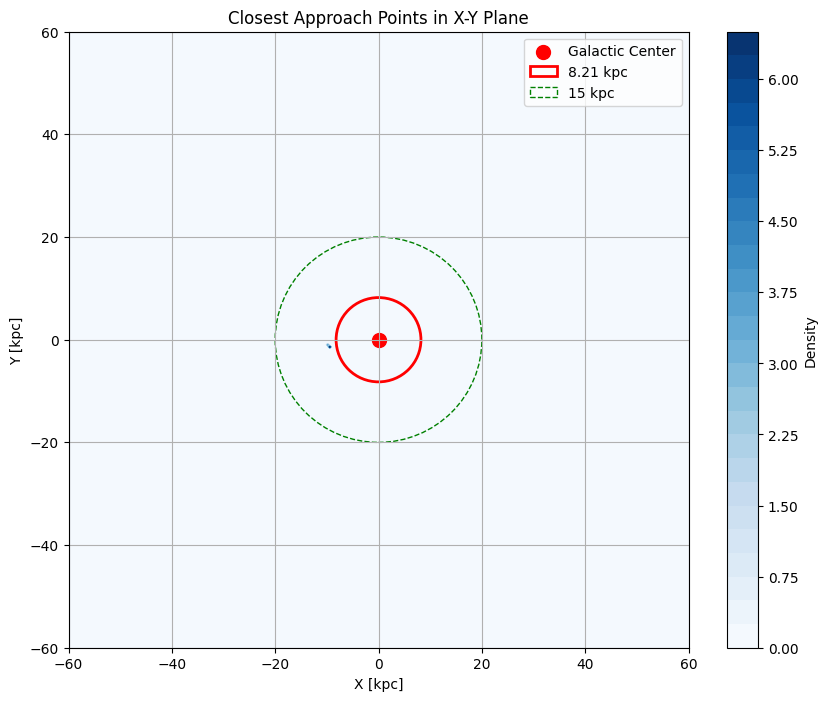

In [452]:
for i in range(len(brown_stars)):
    # print the star ID
    print(brown_stars.iloc[[i]]['ID'])
    plot_closest_origins(plane_crossing[i])

# With their proper motions

In [454]:

plane_crossing = []
for i in tqdm(range(len(brown_stars))):
    origins = integrate_orbits_to_plane_crossing_agama(brown_stars.iloc[[i]], integration_time=-0.1, n_samples=1000,
                                                    pmra_col='mu_ra',
                                                    pmdec_col='mu_dec',
                                                    pmra_error_col='mu_ra_error',
                                                    pmdec_error_col='mu_dec_error')
    plane_crossing.append(origins)



                                                            

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:55<00:00,  3.72s/it]


0    HVS1
Name: ID, dtype: object


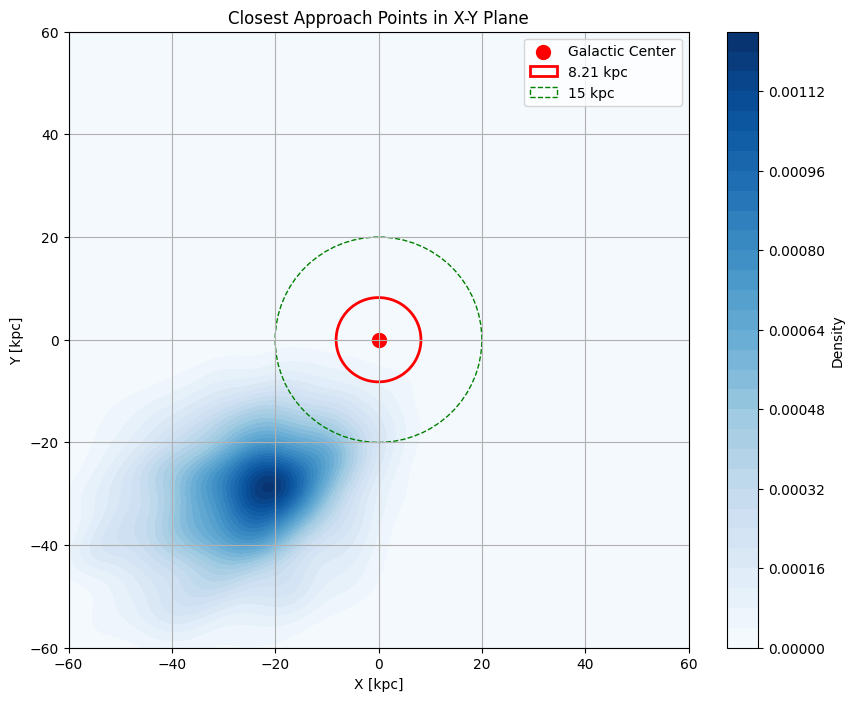

1    HVS2
Name: ID, dtype: object


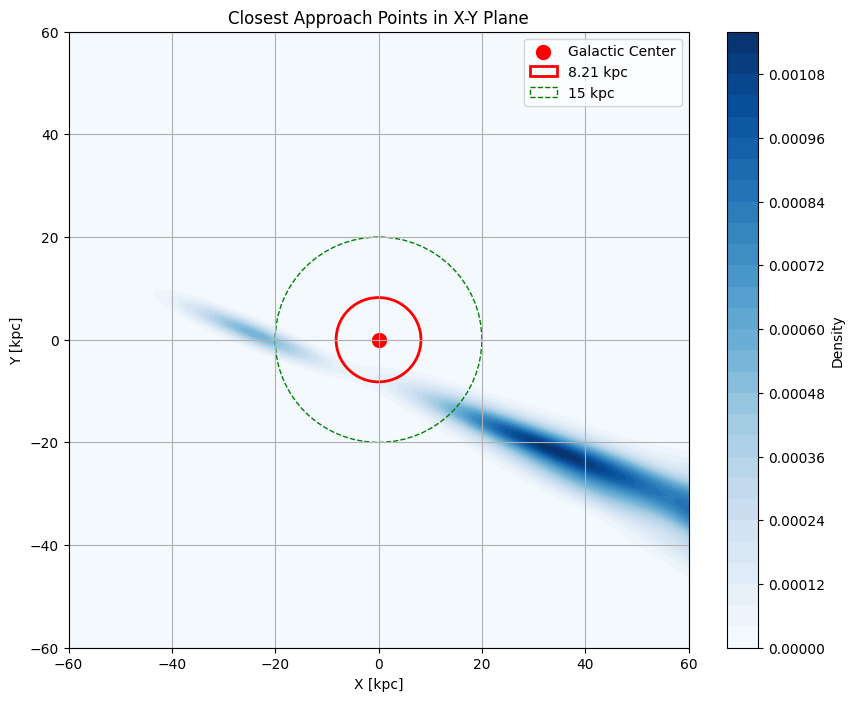

2    HVS3
Name: ID, dtype: object


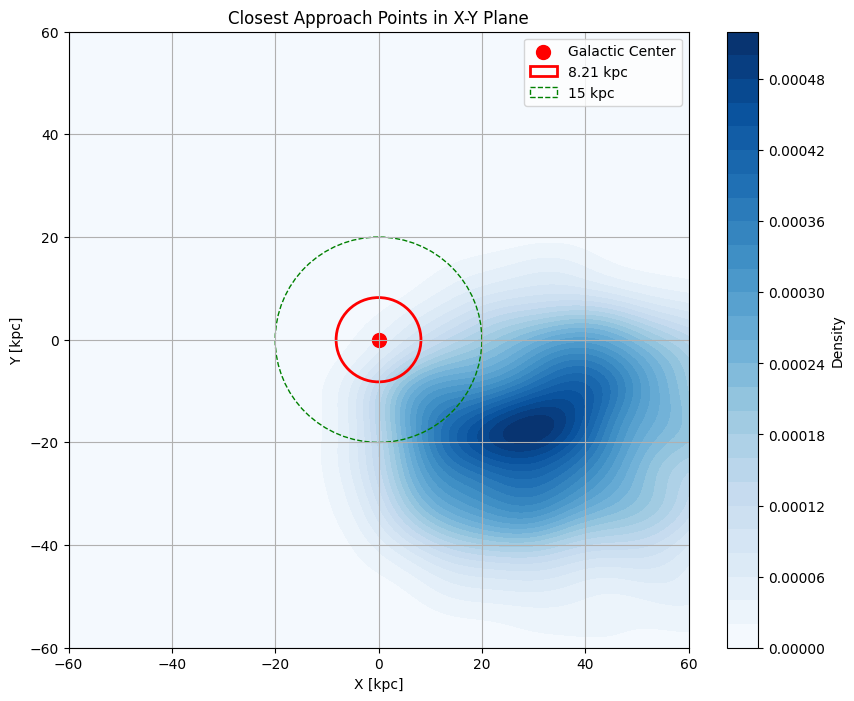

3    HVS4
Name: ID, dtype: object


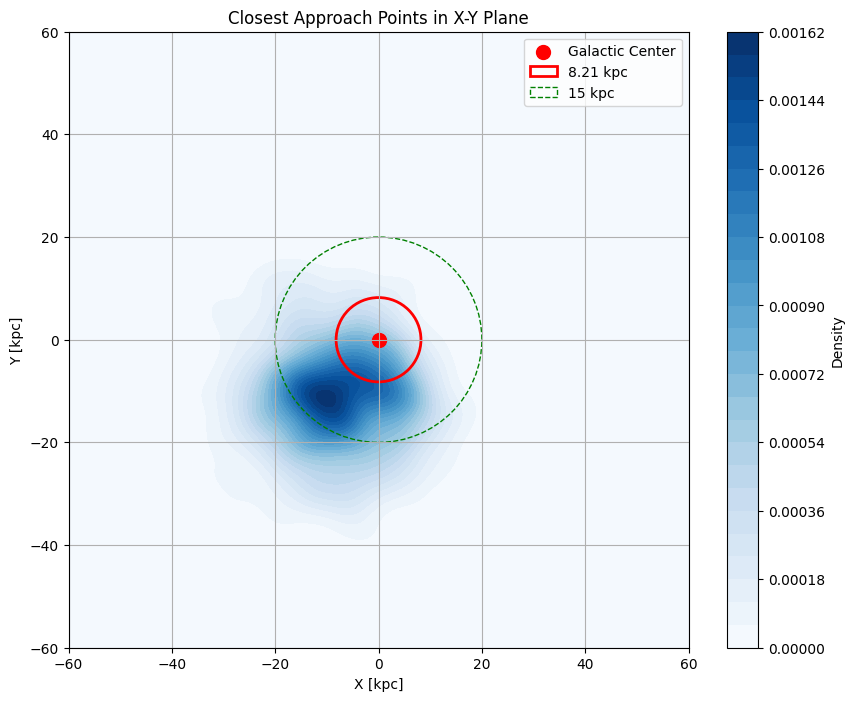

4    HVS5
Name: ID, dtype: object


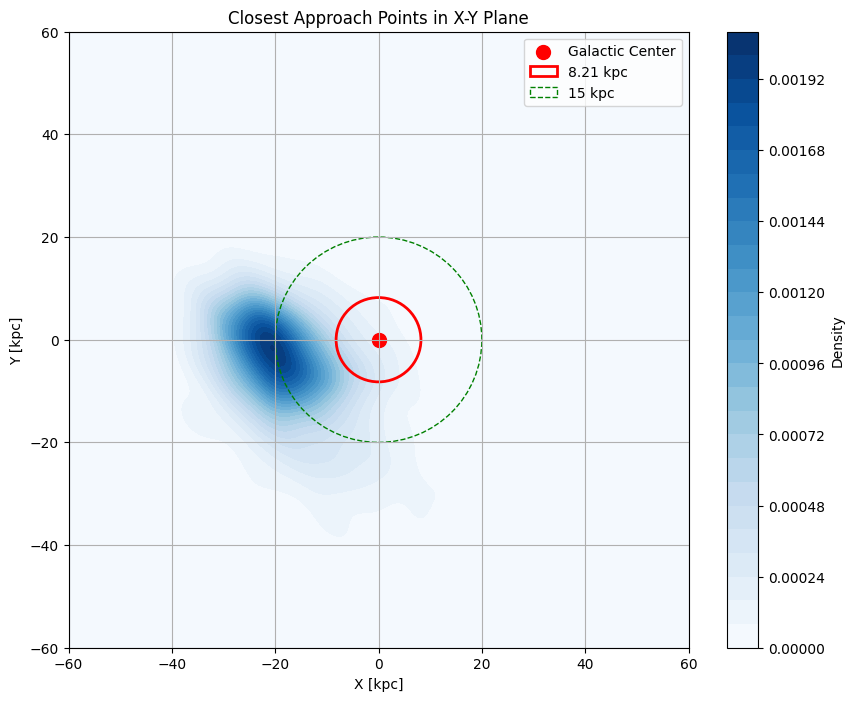

5    HVS7
Name: ID, dtype: object


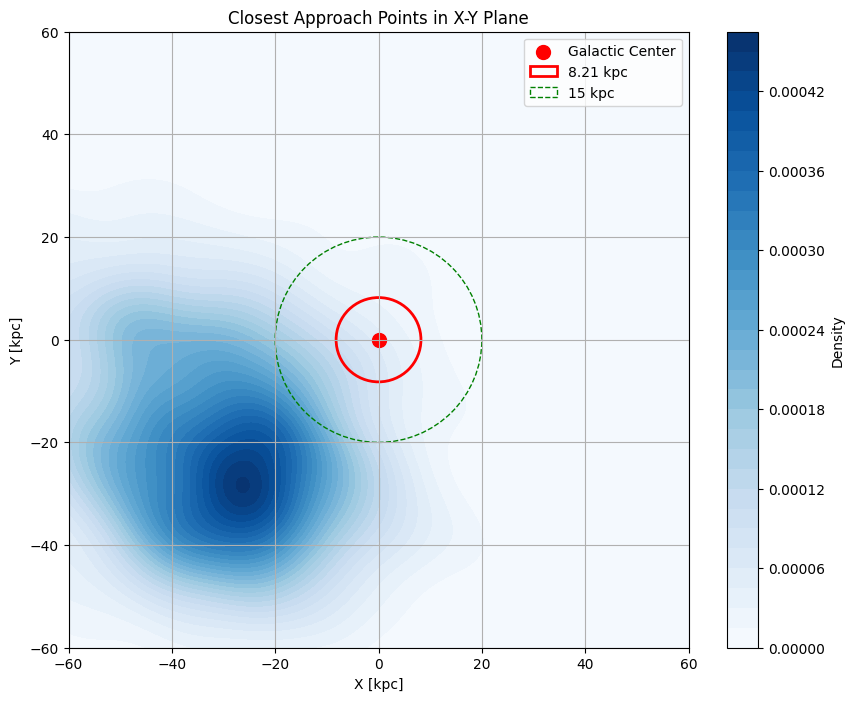

6    HVS8
Name: ID, dtype: object


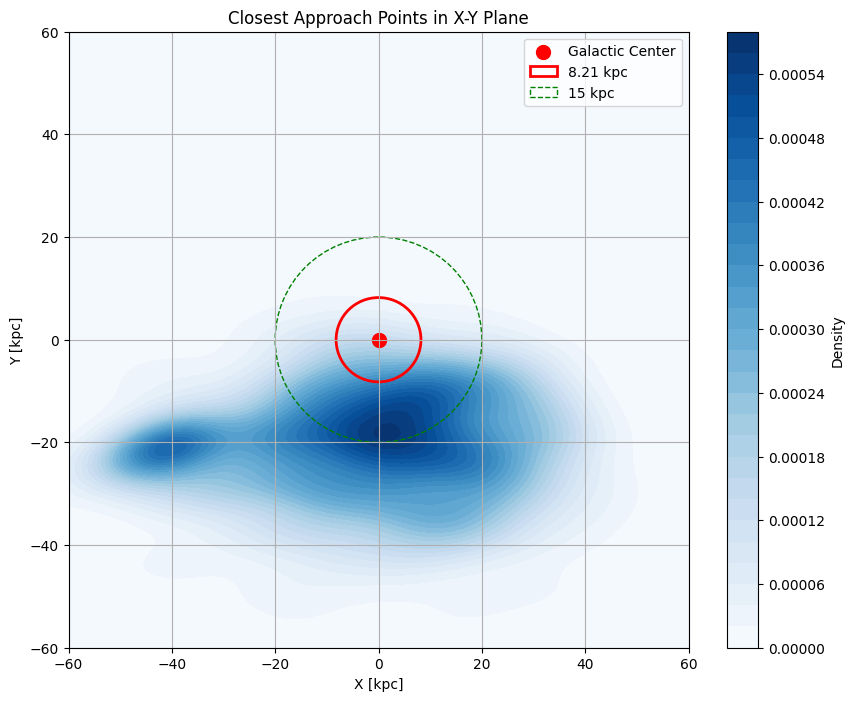

7    HVS9
Name: ID, dtype: object


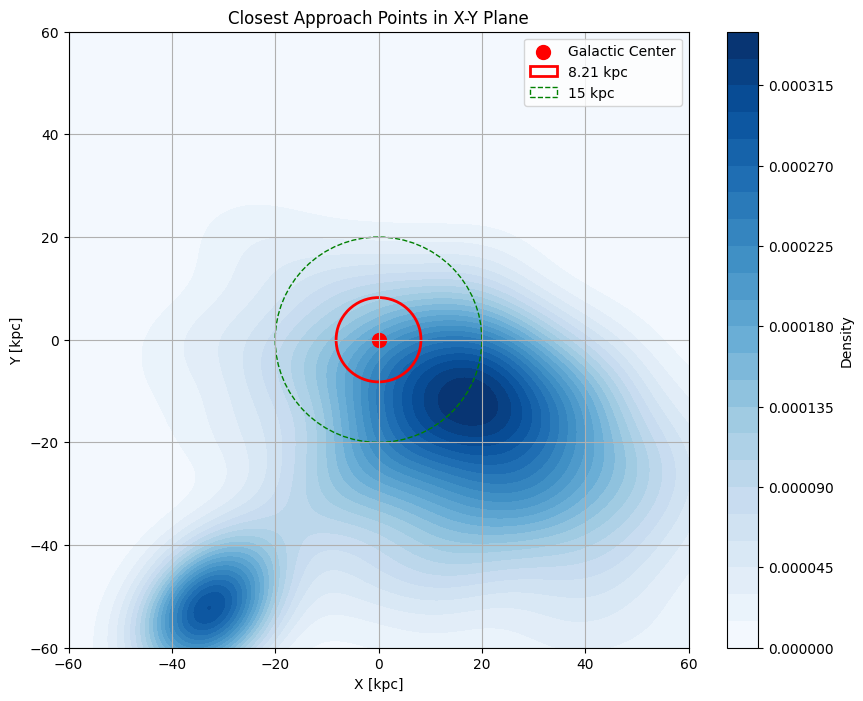

8    HVS10
Name: ID, dtype: object


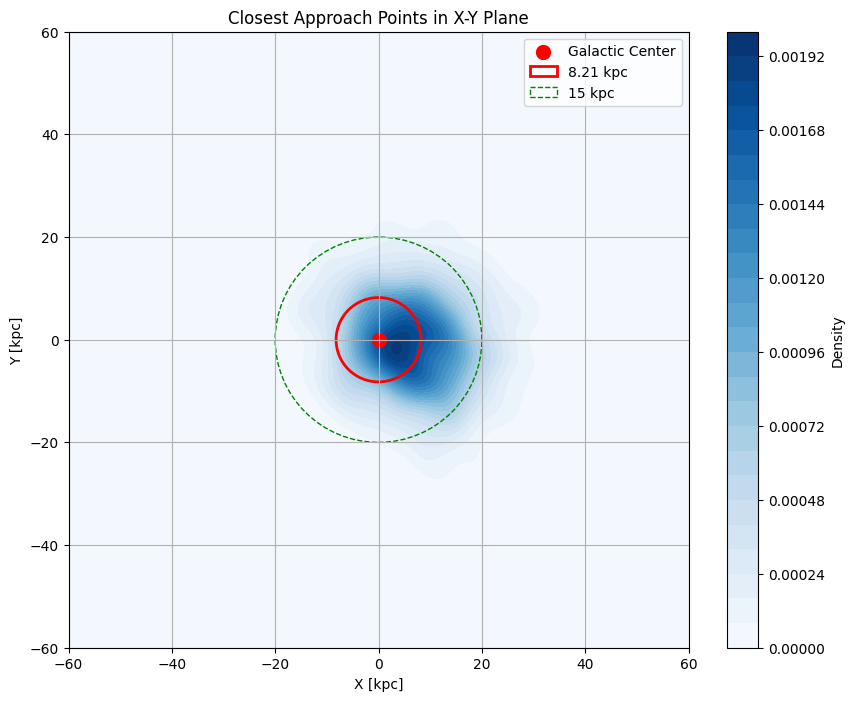

9    HVS12
Name: ID, dtype: object


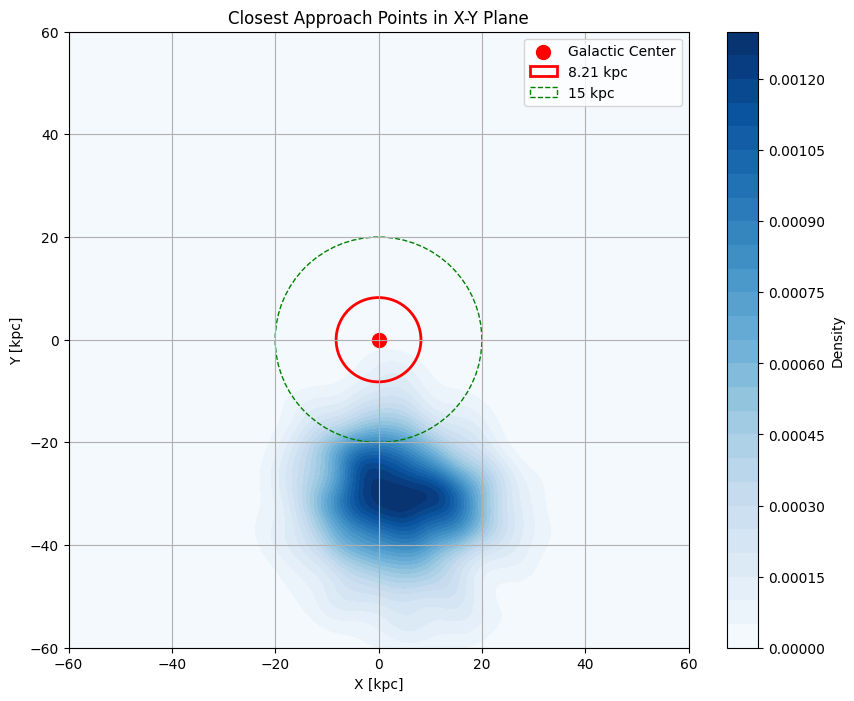

10    HVS13
Name: ID, dtype: object


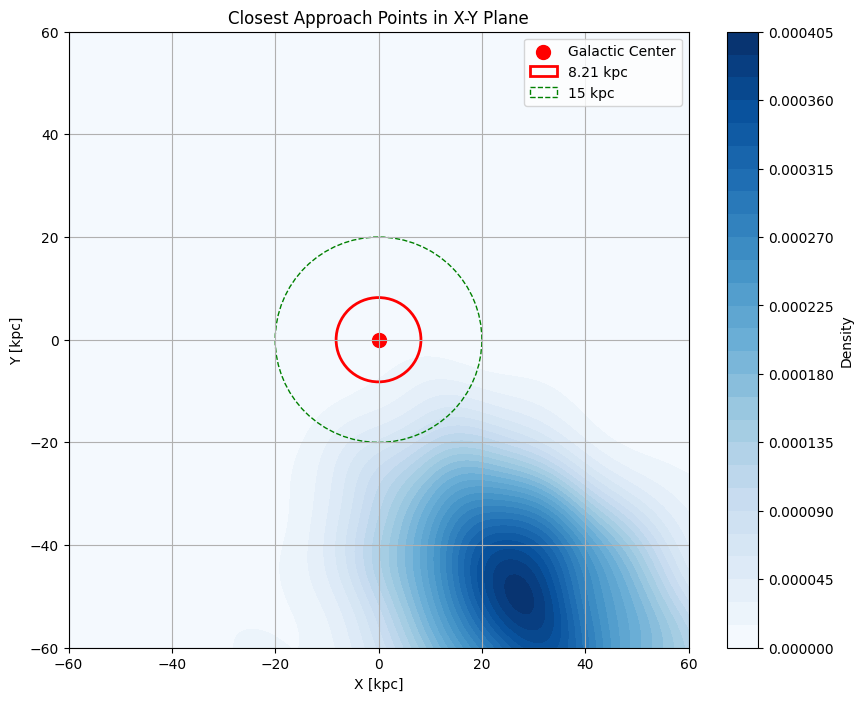

11    B434
Name: ID, dtype: object


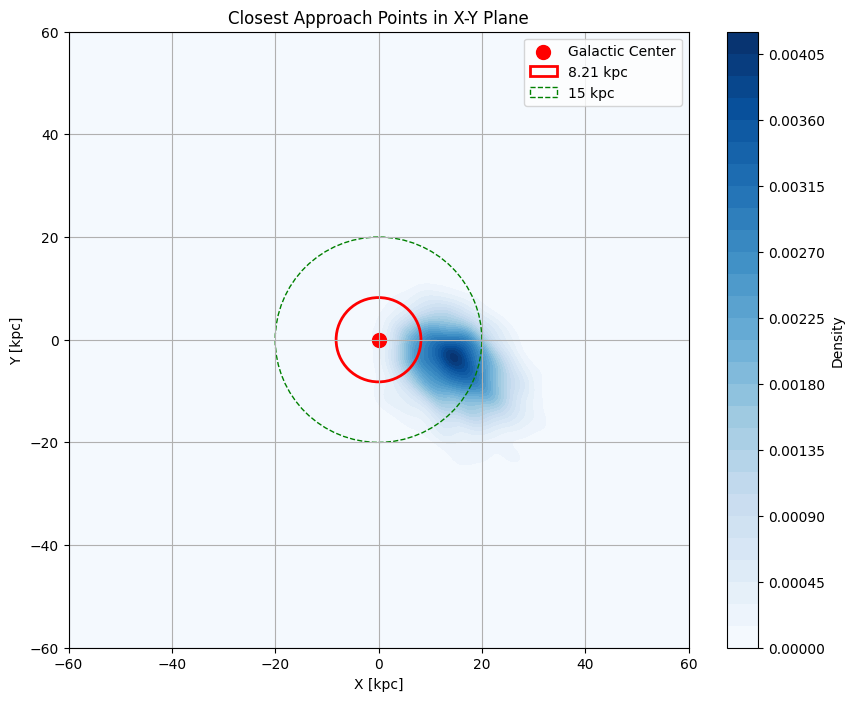

12    B485
Name: ID, dtype: object


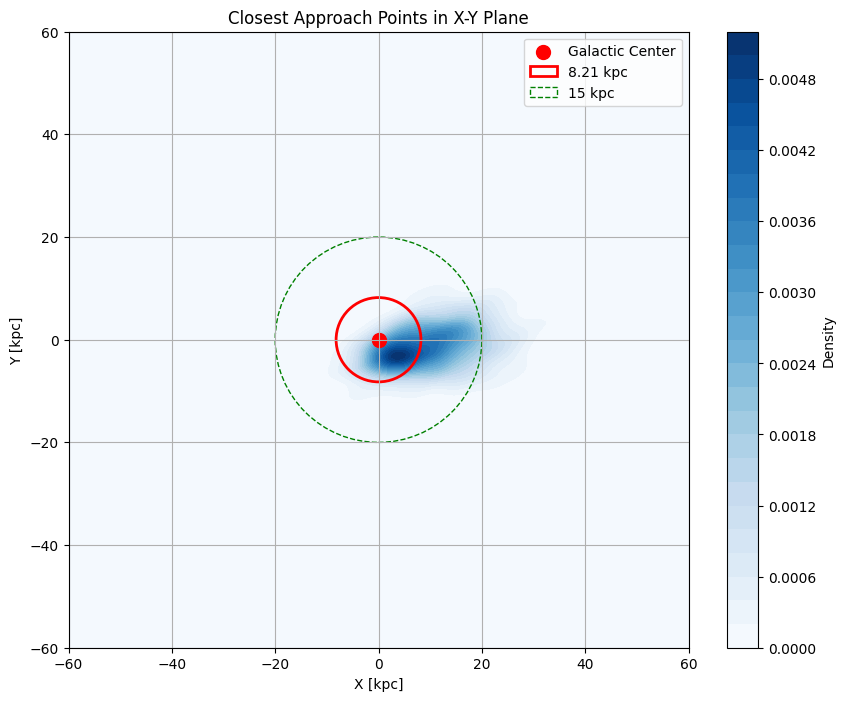

13    B711
Name: ID, dtype: object


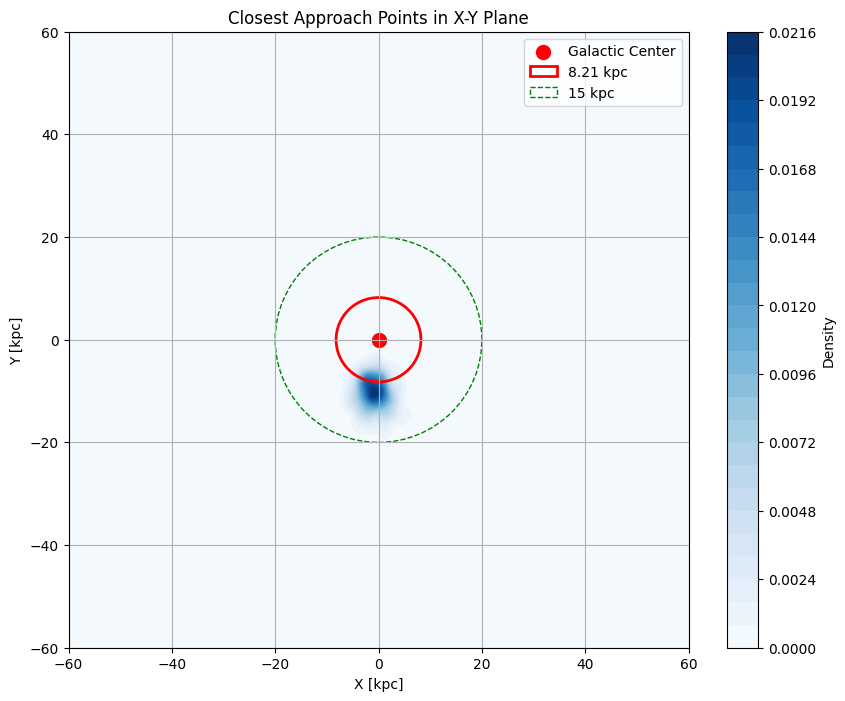

14    B733
Name: ID, dtype: object


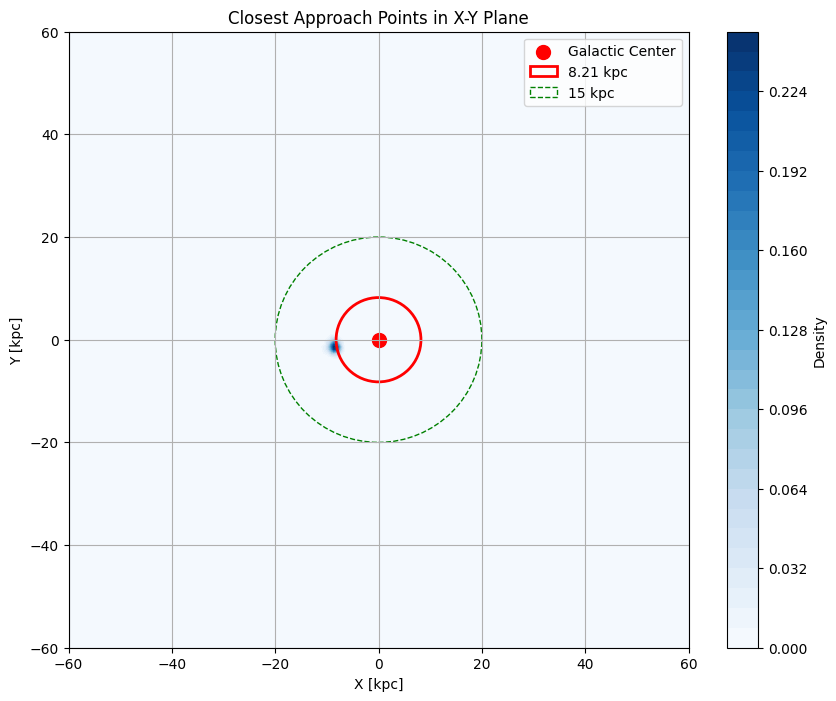

In [455]:
for i in range(len(brown_stars)):
    # print the star ID
    print(brown_stars.iloc[[i]]['ID'])
    plot_closest_origins(plane_crossing[i])

# HVS 10 Hubble x Gaia proper motions

RMS(PM_HST+Gaia - PM_Gaia) = (7.9911e-01, 2.3799e+00) m.a.s.
PM variation = (-2.4526e+00, -1.0457e+00)  m.a.s.

 - A total of 5 stars were used during the epoch alignment.
 - Absolute PM of the used stars: 
    - 5 stars were used to compute the wmean absolute frame:
       - wmean pmra = -4.28+-0.08 
       - wmean pmdec = -1.77+-0.05 
    - 5 stars were used to compute the mean absolute frame:
       - mean pmra = -3.0+-1.0 
       - mean pmdec = -3.0+-2.0 
    - 5 stars were used to compute the median absolute frame:
       - median pmra = -2.0+-1.0 
       - median pmdec = -5.0+-2.0 

In [543]:
# load data 
hvs10 = Table.read('Data/Brown_targets/hvs10_hubblexgaia.fits')
hvs10 = hvs10.to_pandas()

/usr/local/lib/python3.10/site-packages/astropy/units/core.py:2158: UnitsWarning: 'hms' did not parse as fits unit: At col 0, Unit 'hms' not supported by the FITS standard. Did you mean hm? If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)



In [544]:
# with Hubble data alone
hvs10_gaia = brown_stars.loc[brown_stars['ID'] == 'HVS10']
origin_hvs10 = integrate_orbits_to_plane_crossing_agama(hvs10_gaia, n_samples=1000, integration_time=-0.1,
                                                          ra_col='ra', dec_col='dec',
                                                          pmra_col = 'mu_ra', 
                                                          pmdec_col='mu_dec', 
                                                          pmra_error_col='mu_ra_error', 
                                                          pmdec_error_col='mu_dec_error')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.11it/s]


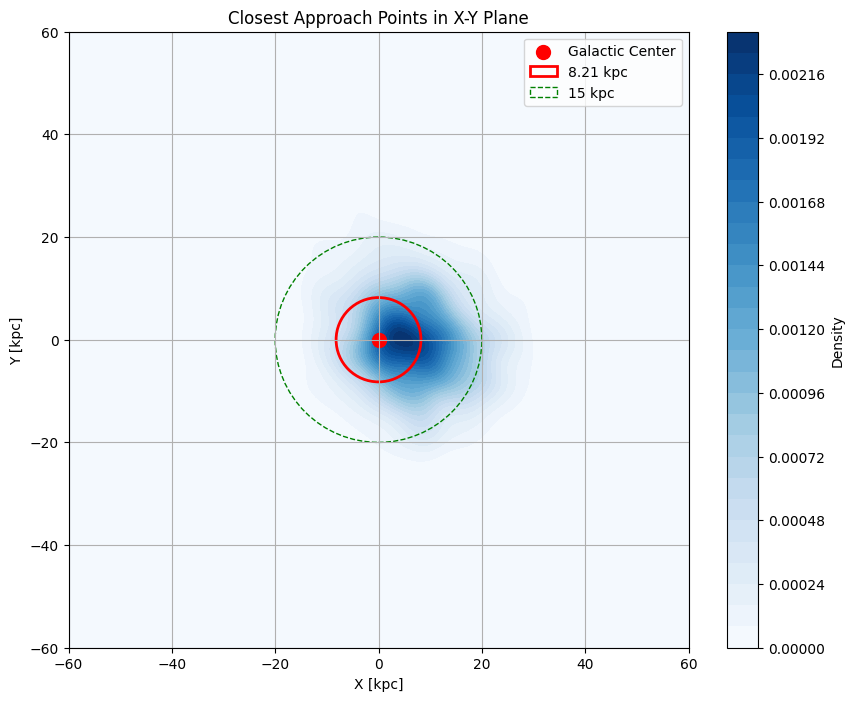

In [545]:
plot_closest_origins(origin_hvs10)

/tmp/ipykernel_15/3344737526.py:50: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'],



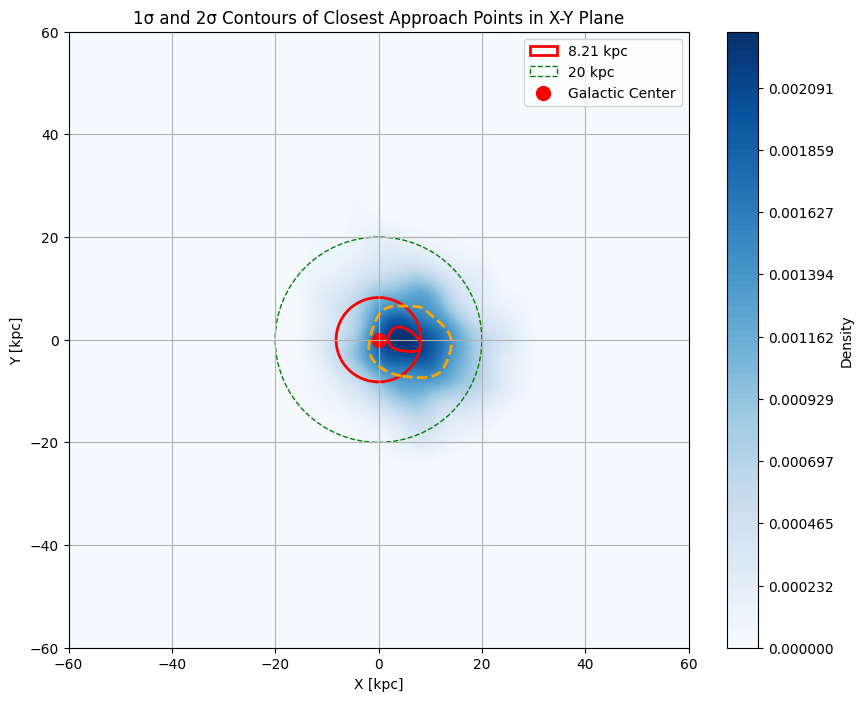

In [547]:
plot_sigma_contours(origin_hvs10)

In [550]:
# with Gaia data alone
origin_hvs10 = integrate_orbits_to_plane_crossing_agama(hvs10, n_samples=1000, integration_time=-0.1,
                                                          ra_col='ra_1', dec_col='dec_1',
                                                          pmra_col = 'pmra', 
                                                          pmdec_col='pmdec', 
                                                          pmra_error_col='pmra_error', 
                                                          pmdec_error_col='pmdec_error')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 284.48it/s]


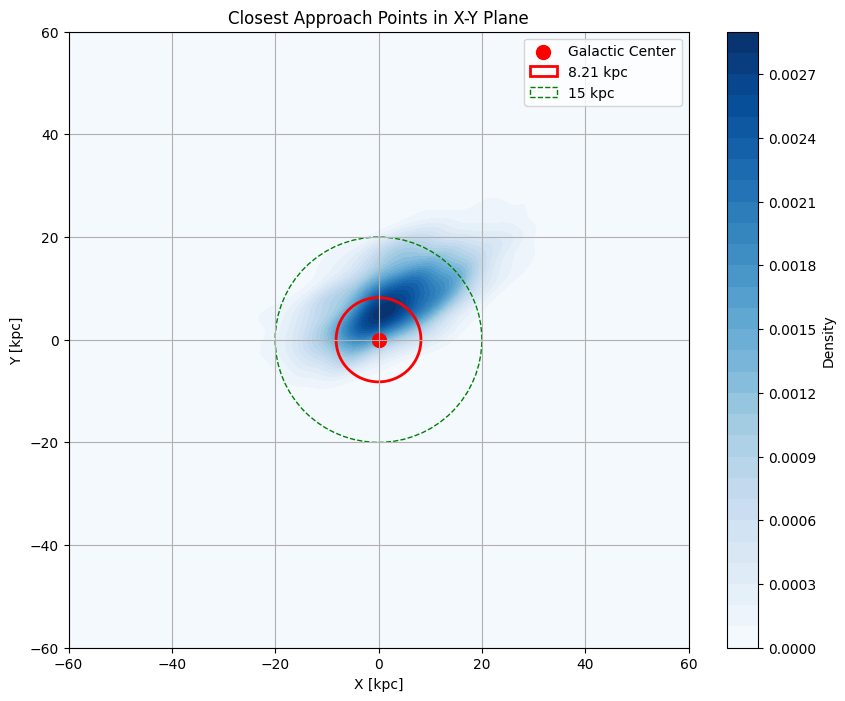

In [551]:
plot_closest_origins(origin_hvs10)

/tmp/ipykernel_15/3344737526.py:50: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'],



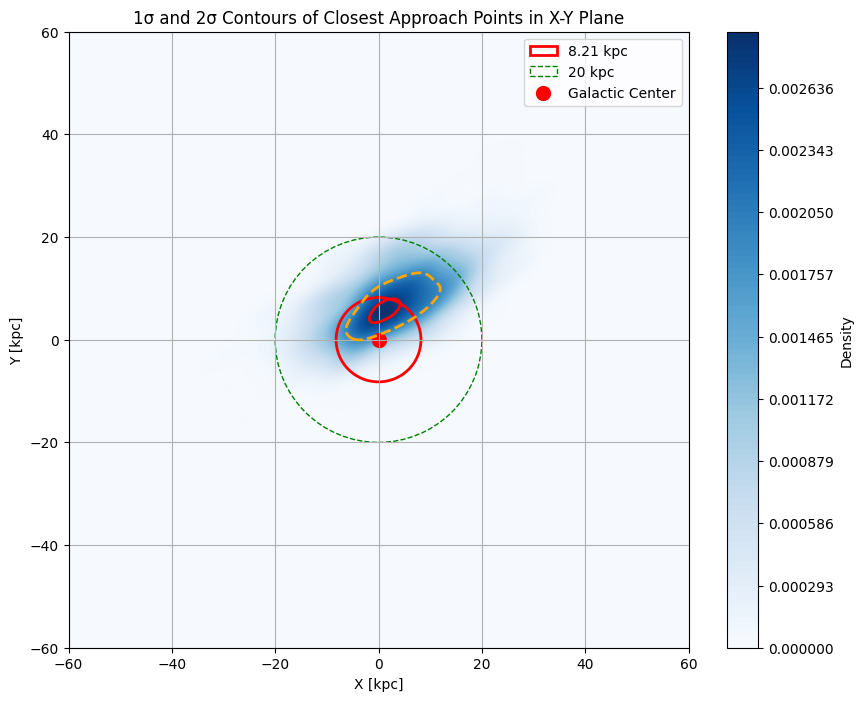

In [552]:
plot_sigma_contours(origin_hvs10)

In [539]:
# how different are hubble and gaia proper motions
print('pmra difference',hvs10['pmra'].values - hvs10['hst_gaia_pmra_wmean'].values, 'with errors', hvs10['pmra_error'].values, hvs10['hst_gaia_pmra_wmean_error'].values)
print('pmdec difference',hvs10['pmdec'].values - hvs10['hst_gaia_pmdec_wmean'].values, 'with errors', hvs10['pmdec_error'].values, hvs10['hst_gaia_pmdec_wmean_error'].values)
#print(hvs10['pmdec'] - hvs10['hst_gaia_pmdec_wmean'])
#print(hvs10['Separation'])


pmra difference [-5.51598944] with errors [0.47303512] [0.14686893]
pmdec difference [1.00702464] with errors [0.21717378] [0.08822546]


In [554]:
hvs10.hst_gaia_pmra_wmean

0    4.43015
Name: hst_gaia_pmra_wmean, dtype: float64

In [555]:
hvs10.pmra

0   -1.085839
Name: pmra, dtype: float64

In [559]:
# with Hubble and Gaia data
origin_hvs10 =integrate_orbits_to_plane_crossing_agama(hvs10, n_samples=1000, integration_time=-0.5,
                                                          ra_col='ra_1', dec_col='dec_1',
                                                          pmra_col = 'hst_gaia_pmra_median', 
                                                          pmdec_col='hst_gaia_pmdec_median', 
                                                          pmra_error_col='hst_gaia_pmra_median_error', 
                                                          pmdec_error_col='hst_gaia_pmdec_median_error')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.43it/s]


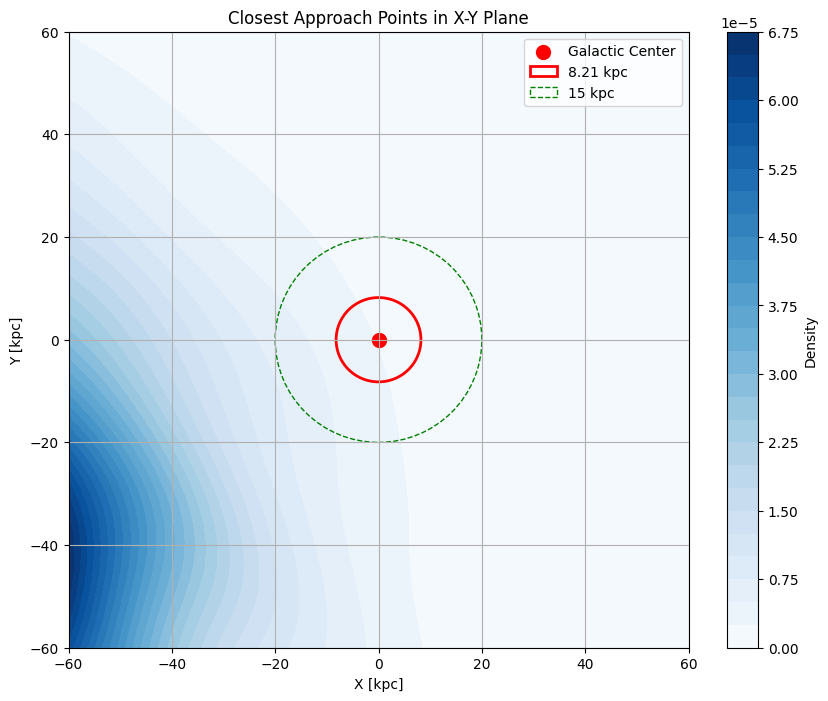

In [560]:
plot_closest_origins(origin_hvs10)

# Plot 1 and 2 $ \sigma $

0    HVS1
Name: ID, dtype: object
/tmp/ipykernel_15/3957738539.py:50: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(xi, yi, zi, levels=[level_1sigma, level_2sigma], colors=['orange', 'red'],



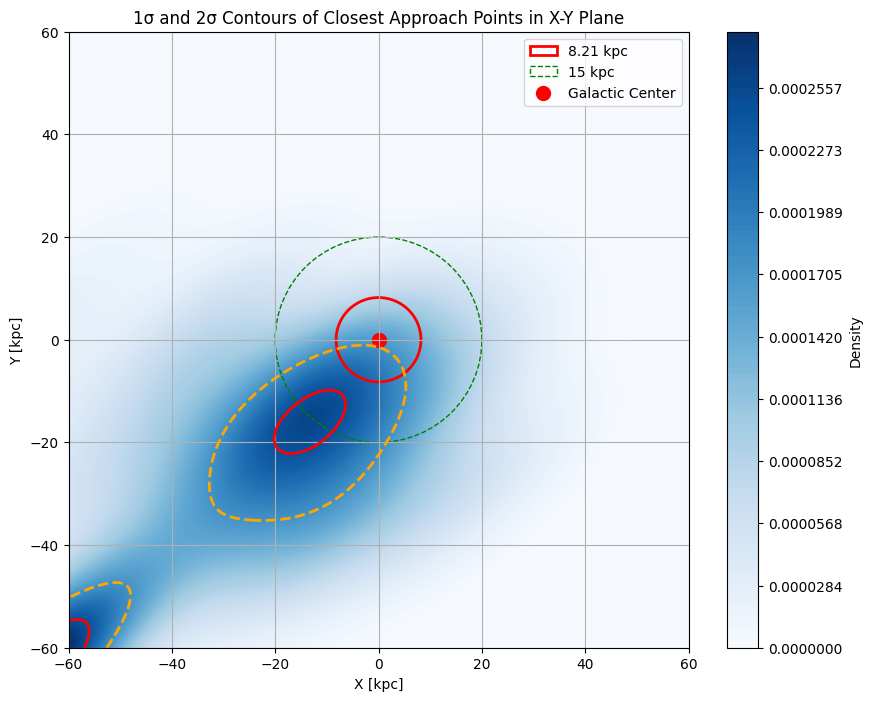

1    HVS2
Name: ID, dtype: object


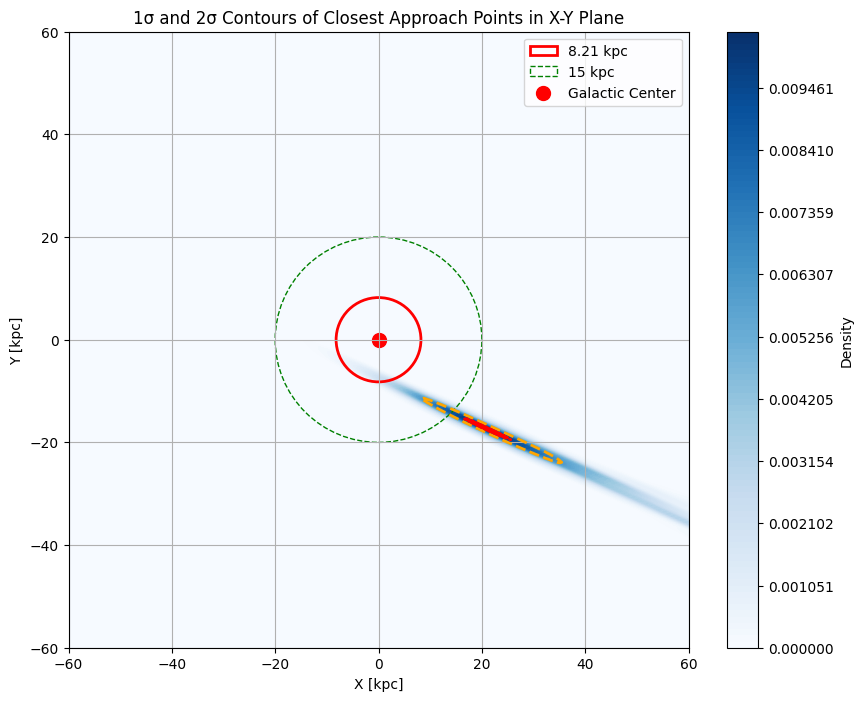

2    HVS3
Name: ID, dtype: object


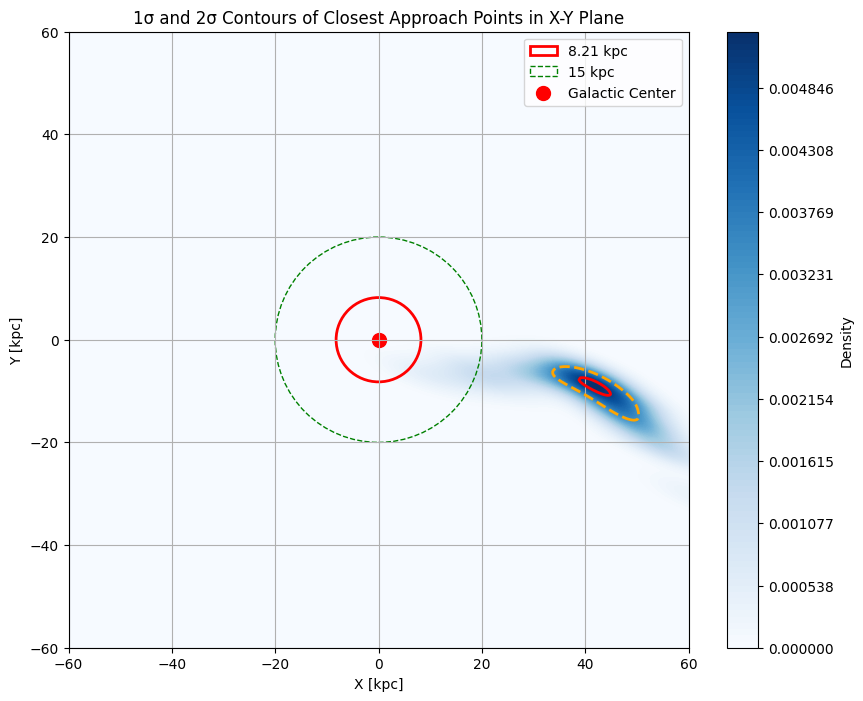

3    HVS4
Name: ID, dtype: object


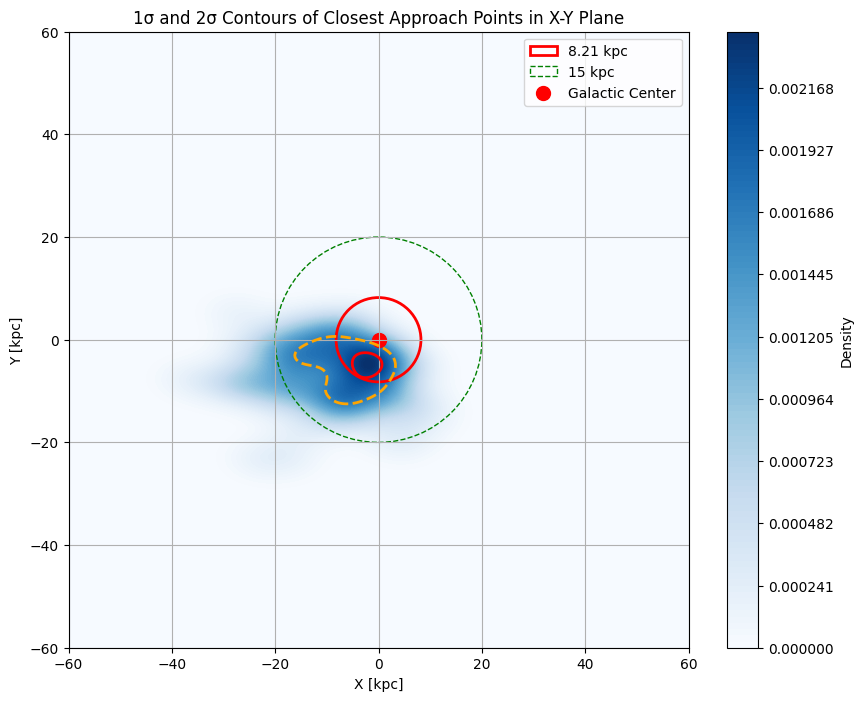

4    HVS5
Name: ID, dtype: object


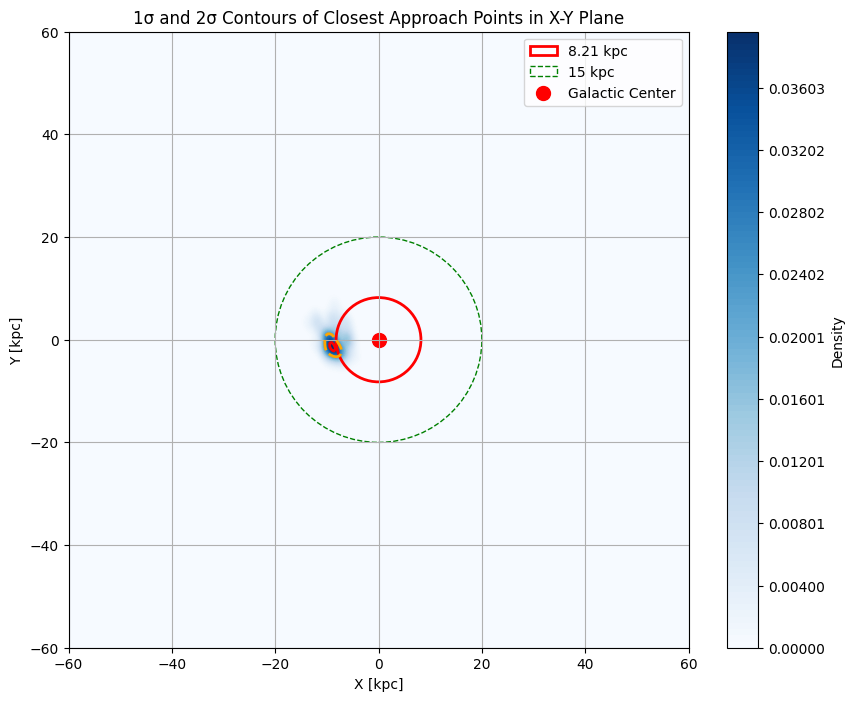

5    HVS7
Name: ID, dtype: object


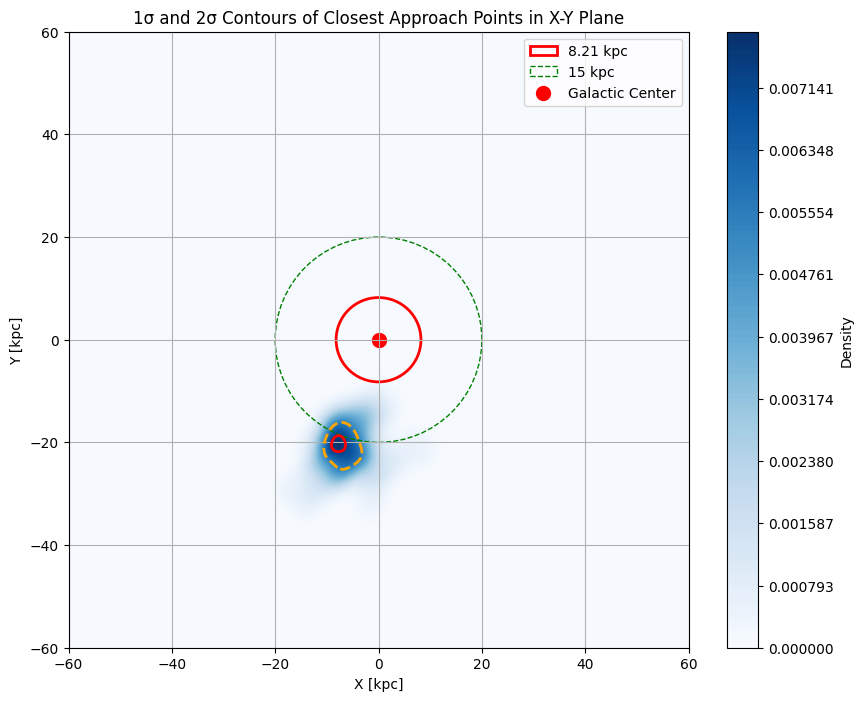

6    HVS8
Name: ID, dtype: object


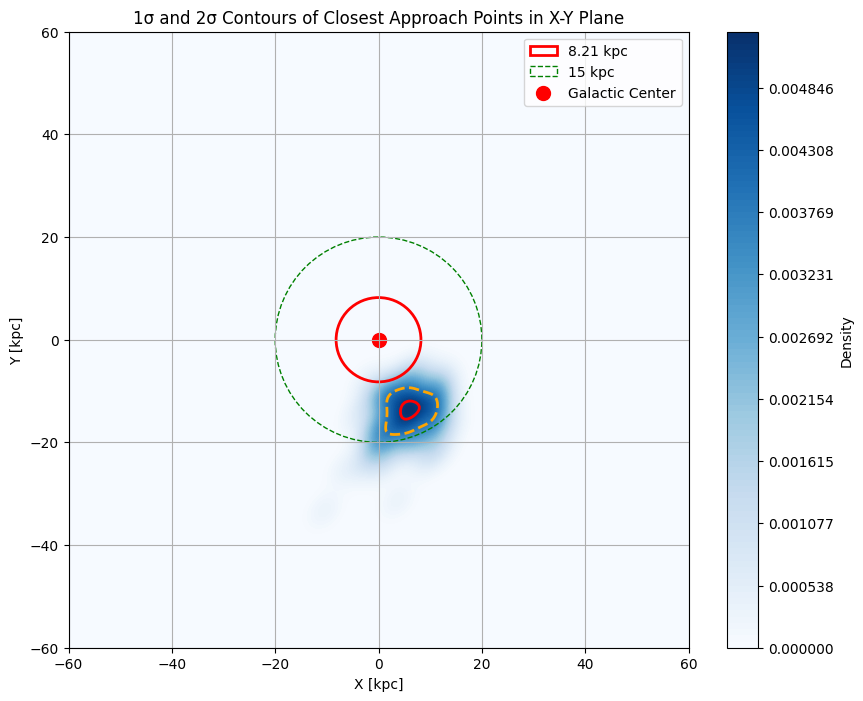

7    HVS9
Name: ID, dtype: object


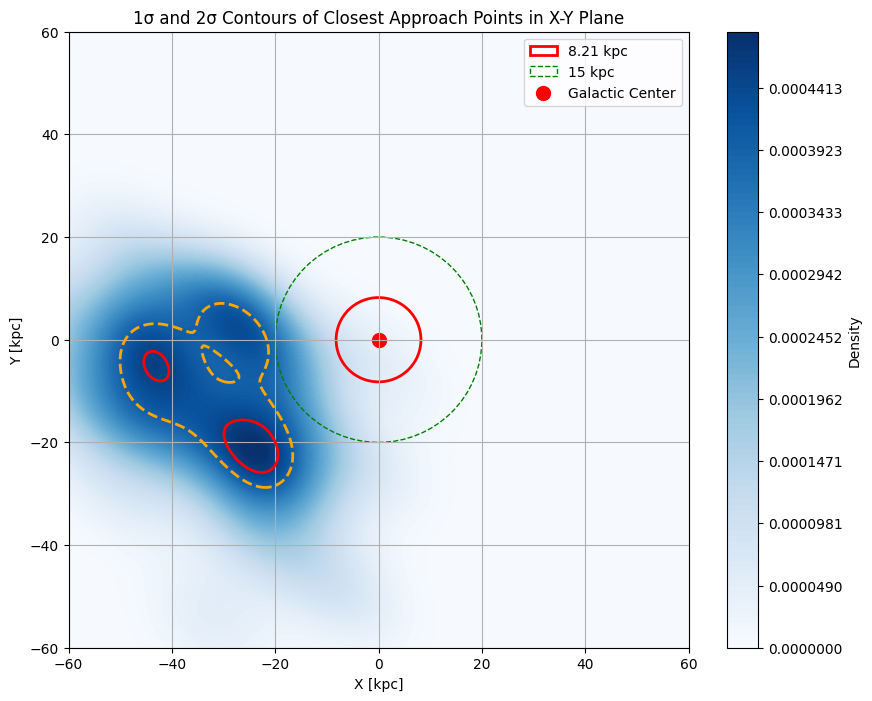

8    HVS10
Name: ID, dtype: object


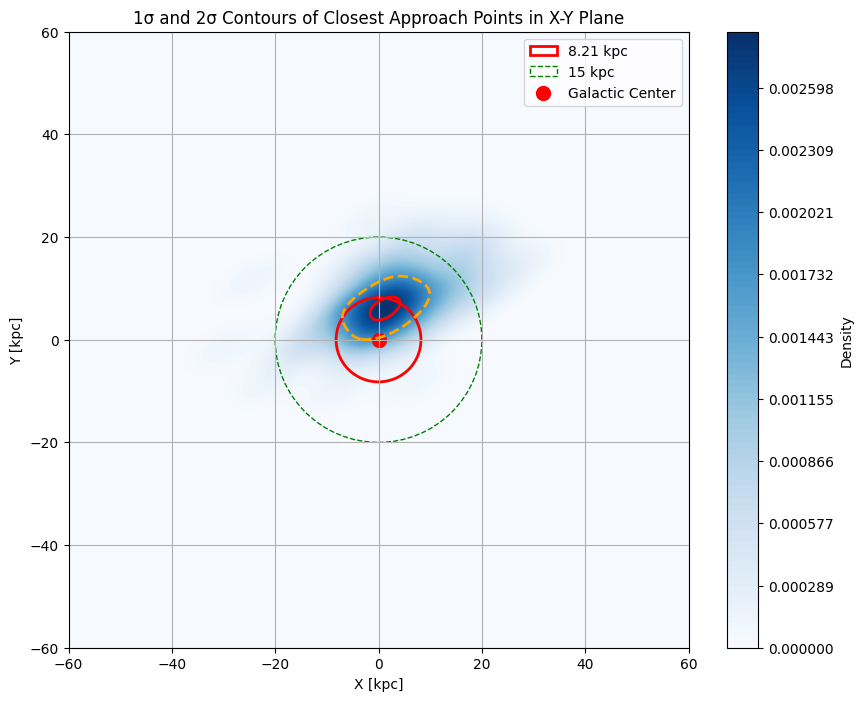

9    HVS12
Name: ID, dtype: object


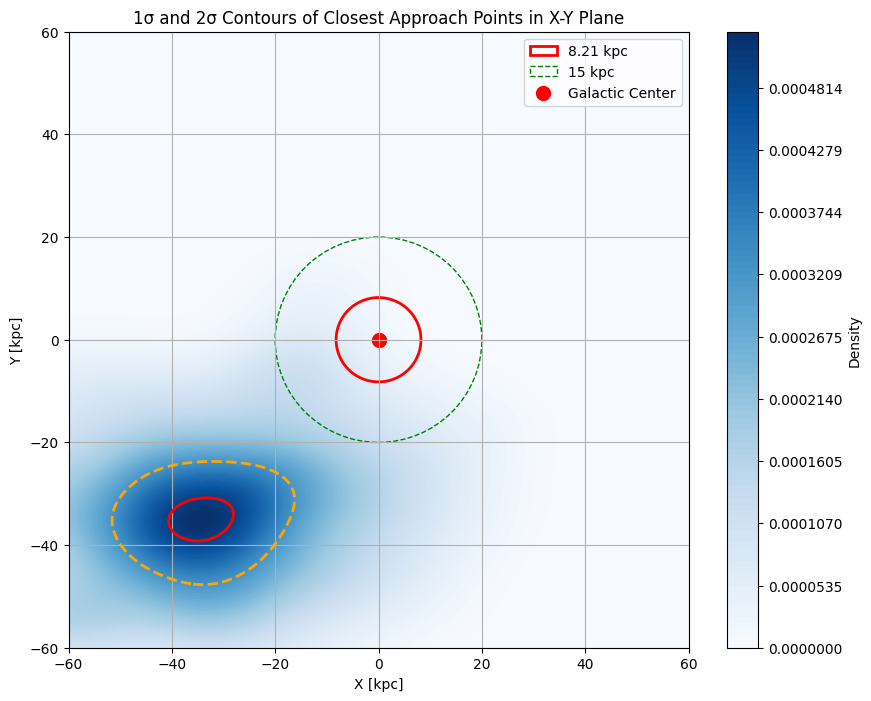

10    HVS13
Name: ID, dtype: object


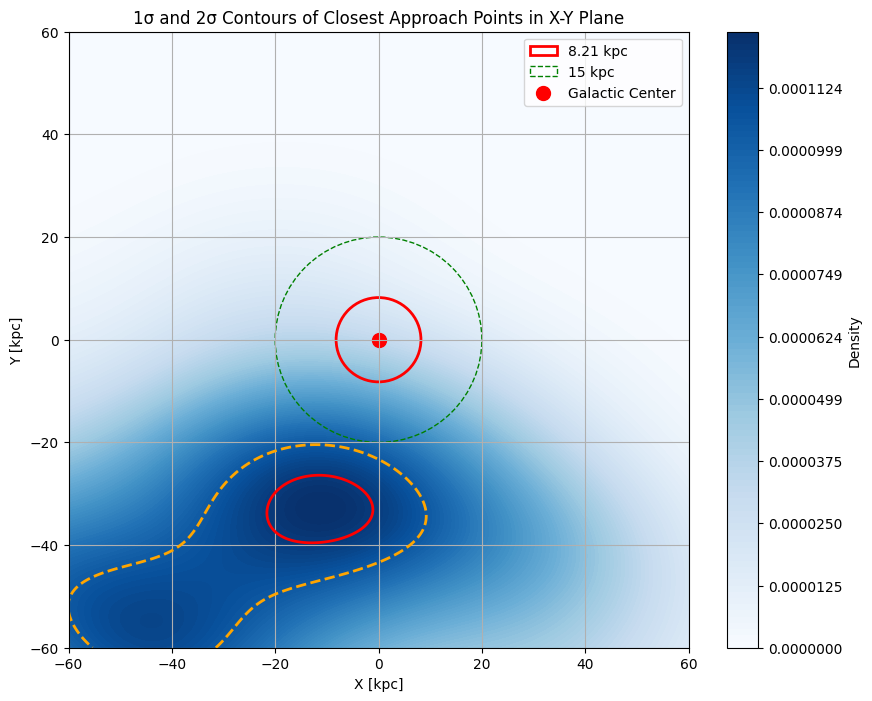

11    B434
Name: ID, dtype: object


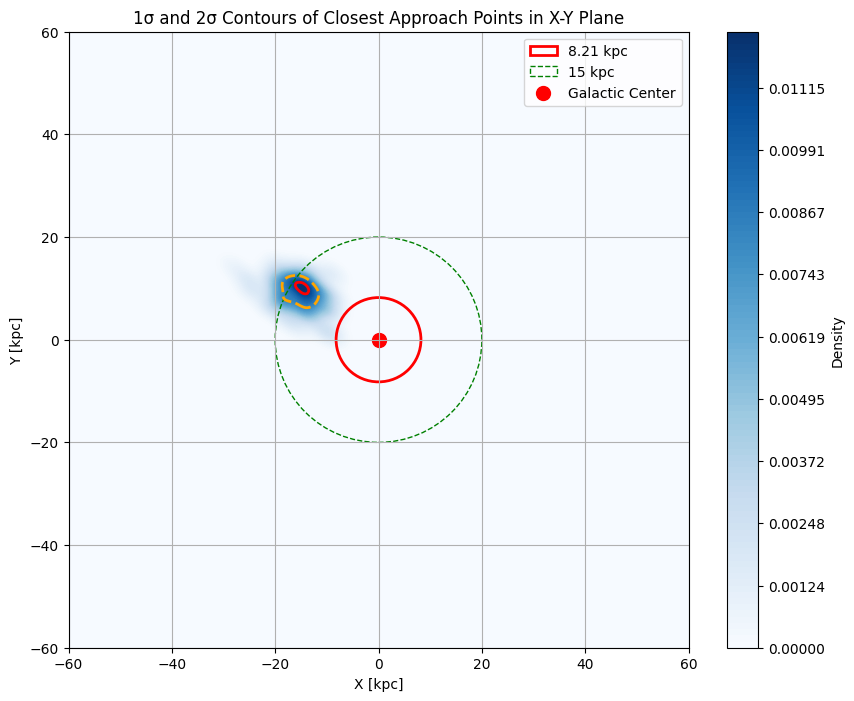

12    B485
Name: ID, dtype: object


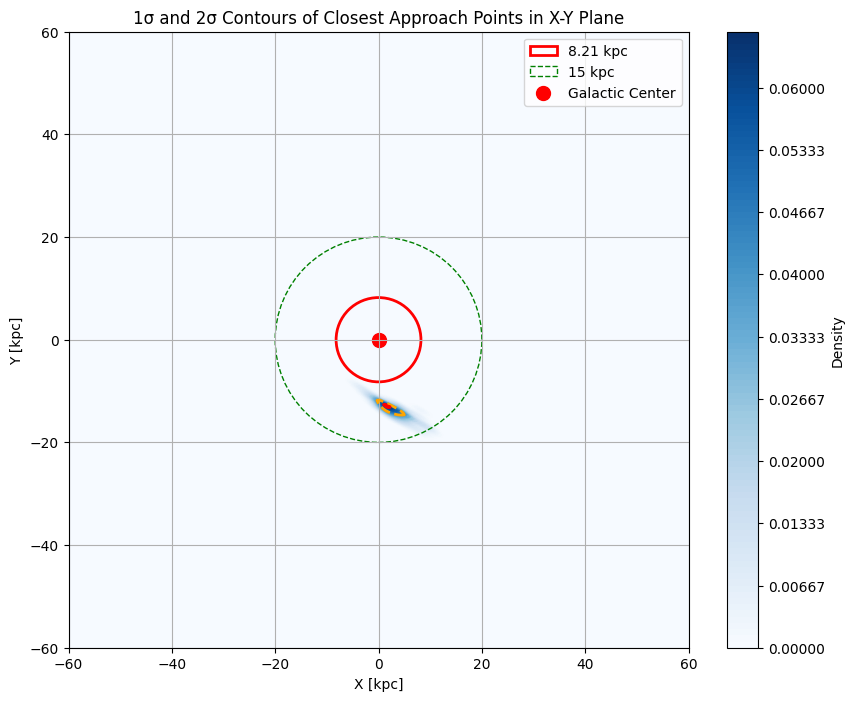

13    B711
Name: ID, dtype: object


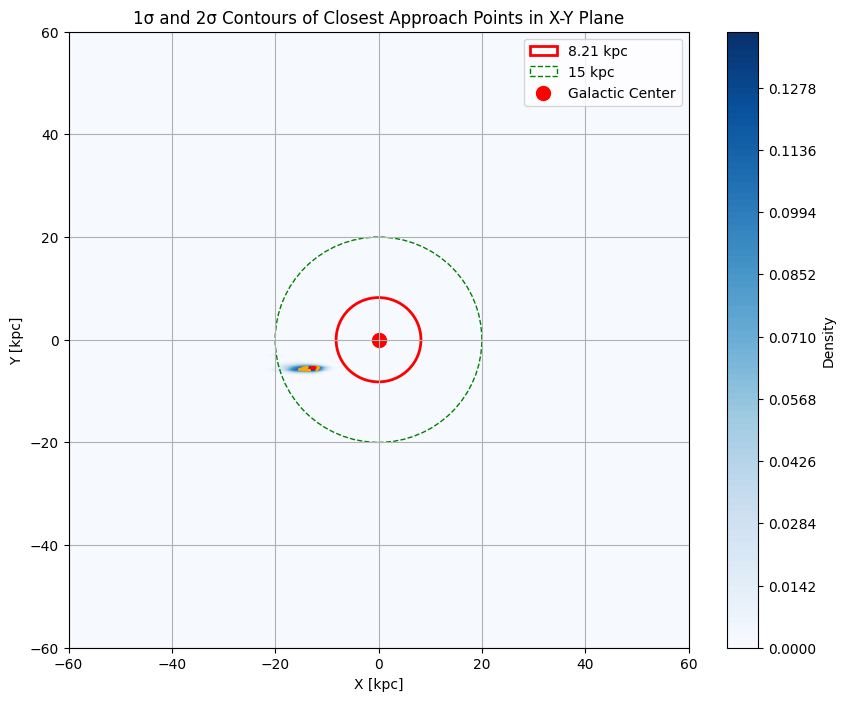

14    B733
Name: ID, dtype: object


ValueError: Contour levels must be increasing

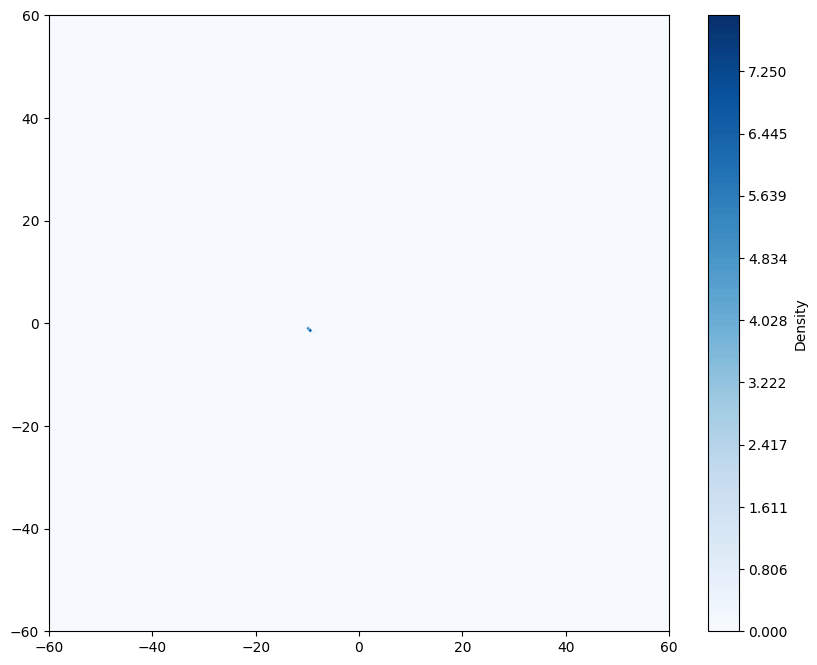

In [450]:
for i in range(len(brown_stars)):
    # print the star ID
    print(brown_stars.iloc[[i]]['ID'])
    plot_sigma_contours(plane_crossing[i])